# Logistic Regression Prediction Analysis on Patient Data Code

# Research Question:

What variables best predict if a patient will be readmitted within a month after release from their initial visit?

# Install necessary libraries:

Install libraries needed for this analysis.

In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install seaborn
!pip install imblearn

# Import necessary packages:

Import packages needed for this analysis.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from patsy import dmatrices
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVR

# Load data set:

Load the medical_clean.csv data set into a dataframe then review the information and print.

In [3]:
medical_df = pd.read_csv('medical_clean.csv')
medical_df.info()
print(medical_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CaseOrder           10000 non-null  int64  
 1   Customer_id         10000 non-null  object 
 2   Interaction         10000 non-null  object 
 3   UID                 10000 non-null  object 
 4   City                10000 non-null  object 
 5   State               10000 non-null  object 
 6   County              10000 non-null  object 
 7   Zip                 10000 non-null  int64  
 8   Lat                 10000 non-null  float64
 9   Lng                 10000 non-null  float64
 10  Population          10000 non-null  int64  
 11  Area                10000 non-null  object 
 12  TimeZone            10000 non-null  object 
 13  Job                 10000 non-null  object 
 14  Children            10000 non-null  int64  
 15  Age                 10000 non-null  int64  
 16  Incom

There are 10000 rows and 50 columns as expected. There are no obvious concerns so the import can be considered successful.

# Clean and prepare the dataframe:

Check for duplicated values based on the Customer_id variable since the dictionary for the data set noted that this is a unique ID. Remove any duplicated values and review the dataframe.

In [4]:
medical_df = medical_df.drop_duplicates(subset='Customer_id', keep='first')
medical_df.info()
print(medical_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CaseOrder           10000 non-null  int64  
 1   Customer_id         10000 non-null  object 
 2   Interaction         10000 non-null  object 
 3   UID                 10000 non-null  object 
 4   City                10000 non-null  object 
 5   State               10000 non-null  object 
 6   County              10000 non-null  object 
 7   Zip                 10000 non-null  int64  
 8   Lat                 10000 non-null  float64
 9   Lng                 10000 non-null  float64
 10  Population          10000 non-null  int64  
 11  Area                10000 non-null  object 
 12  TimeZone            10000 non-null  object 
 13  Job                 10000 non-null  object 
 14  Children            10000 non-null  int64  
 15  Age                 10000 non-null  int64  
 16  Incom

No duplicate values were found based on the data set as none were removed.

Check for null values in the data set.

In [5]:
medical_df.isnull().sum()

CaseOrder             0
Customer_id           0
Interaction           0
UID                   0
City                  0
State                 0
County                0
Zip                   0
Lat                   0
Lng                   0
Population            0
Area                  0
TimeZone              0
Job                   0
Children              0
Age                   0
Income                0
Marital               0
Gender                0
ReAdmis               0
VitD_levels           0
Doc_visits            0
Full_meals_eaten      0
vitD_supp             0
Soft_drink            0
Initial_admin         0
HighBlood             0
Stroke                0
Complication_risk     0
Overweight            0
Arthritis             0
Diabetes              0
Hyperlipidemia        0
BackPain              0
Anxiety               0
Allergic_rhinitis     0
Reflux_esophagitis    0
Asthma                0
Services              0
Initial_days          0
TotalCharge           0
Additional_charg

The list shows that there are no null values in the data set.

There are columns with non-descript titles so those will be updated to reflect a description based on the corresponding response noted by the dictionary for the data set.  Review the updated dataframe for changes.

In [6]:
medical_df.rename(columns = {'Item1':'Timely_admission',
					'Item2':'Timely_treatment',
					'Item3':'Timely_visits',
					'Item4':'Reliability',
					'Item5':'Options',
					'Item6':'Hours_of_treatment',
					'Item7':'Courteous_staff',
					'Item8':'Evidence_of_active_listening_from_doctor'},
			inplace=True)
medical_df.info()
print(medical_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CaseOrder                                 10000 non-null  int64  
 1   Customer_id                               10000 non-null  object 
 2   Interaction                               10000 non-null  object 
 3   UID                                       10000 non-null  object 
 4   City                                      10000 non-null  object 
 5   State                                     10000 non-null  object 
 6   County                                    10000 non-null  object 
 7   Zip                                       10000 non-null  int64  
 8   Lat                                       10000 non-null  float64
 9   Lng                                       10000 non-null  float64
 10  Population                         

All columns descriptions now are clear based on what data they contain.

Create dummy variables for the categorical variables to be used in the model.

In [7]:
# Create dummies for the ReAdmis variable
medical_df_prep = pd.get_dummies(medical_df, prefix="ReAdmis", columns=['ReAdmis'])
medical_df_prep = medical_df_prep.drop('ReAdmis_No', axis=1)
medical_df_prep = medical_df_prep.rename(columns={'ReAdmis_Yes': "ReAdmis_Yes"})
medical_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CaseOrder                                 10000 non-null  int64  
 1   Customer_id                               10000 non-null  object 
 2   Interaction                               10000 non-null  object 
 3   UID                                       10000 non-null  object 
 4   City                                      10000 non-null  object 
 5   State                                     10000 non-null  object 
 6   County                                    10000 non-null  object 
 7   Zip                                       10000 non-null  int64  
 8   Lat                                       10000 non-null  float64
 9   Lng                                       10000 non-null  float64
 10  Population                         

In [8]:
# Create dummies for the Gender variable
medical_df_prep = pd.get_dummies(medical_df_prep, prefix="Gender", columns=['Gender'])
medical_df_prep = medical_df_prep.rename(columns={'Male': "Gender_Male", 'Female': "Gender_Female", 'Nonbinary': "Gender_Nonbinary"})
medical_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 52 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CaseOrder                                 10000 non-null  int64  
 1   Customer_id                               10000 non-null  object 
 2   Interaction                               10000 non-null  object 
 3   UID                                       10000 non-null  object 
 4   City                                      10000 non-null  object 
 5   State                                     10000 non-null  object 
 6   County                                    10000 non-null  object 
 7   Zip                                       10000 non-null  int64  
 8   Lat                                       10000 non-null  float64
 9   Lng                                       10000 non-null  float64
 10  Population                         

In [9]:
# Create dummies for the Soft_drink variable
medical_df_prep = pd.get_dummies(medical_df_prep, prefix="Soft_drink", columns=['Soft_drink'])
medical_df_prep = medical_df_prep.drop('Soft_drink_No', axis=1)
medical_df_prep = medical_df_prep.rename(columns={'Soft_drink_Yes': "Soft_drink_Yes"})
medical_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 52 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CaseOrder                                 10000 non-null  int64  
 1   Customer_id                               10000 non-null  object 
 2   Interaction                               10000 non-null  object 
 3   UID                                       10000 non-null  object 
 4   City                                      10000 non-null  object 
 5   State                                     10000 non-null  object 
 6   County                                    10000 non-null  object 
 7   Zip                                       10000 non-null  int64  
 8   Lat                                       10000 non-null  float64
 9   Lng                                       10000 non-null  float64
 10  Population                         

In [10]:
# Create dummies for the Initial_admin variable
medical_df_prep = pd.get_dummies(medical_df_prep, prefix="Initial_admin", columns=['Initial_admin'])
medical_df_prep = medical_df_prep.rename(columns={'Initial_admin_Emergency Admission': "Initial_admin_Emergency", 'Initial_admin_Elective Admission': "Initial_admin_Elective", 'Initial_admin_Observation Admission': "Initial_admin_Observation"})
medical_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 54 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CaseOrder                                 10000 non-null  int64  
 1   Customer_id                               10000 non-null  object 
 2   Interaction                               10000 non-null  object 
 3   UID                                       10000 non-null  object 
 4   City                                      10000 non-null  object 
 5   State                                     10000 non-null  object 
 6   County                                    10000 non-null  object 
 7   Zip                                       10000 non-null  int64  
 8   Lat                                       10000 non-null  float64
 9   Lng                                       10000 non-null  float64
 10  Population                         

In [11]:
# Create dummies for the HighBlood variable
medical_df_prep = pd.get_dummies(medical_df_prep, prefix="HighBlood", columns=['HighBlood'])
medical_df_prep = medical_df_prep.drop('HighBlood_No', axis=1)
medical_df_prep = medical_df_prep.rename(columns={'HighBlood_Yes': "HighBlood_Yes"})
medical_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 54 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CaseOrder                                 10000 non-null  int64  
 1   Customer_id                               10000 non-null  object 
 2   Interaction                               10000 non-null  object 
 3   UID                                       10000 non-null  object 
 4   City                                      10000 non-null  object 
 5   State                                     10000 non-null  object 
 6   County                                    10000 non-null  object 
 7   Zip                                       10000 non-null  int64  
 8   Lat                                       10000 non-null  float64
 9   Lng                                       10000 non-null  float64
 10  Population                         

In [12]:
# Create dummies for the Stroke variable
medical_df_prep = pd.get_dummies(medical_df_prep, prefix="Stroke", columns=['Stroke'])
medical_df_prep = medical_df_prep.drop('Stroke_No', axis=1)
medical_df_prep = medical_df_prep.rename(columns={'Stroke_Yes': "Stroke_Yes"})
medical_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 54 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CaseOrder                                 10000 non-null  int64  
 1   Customer_id                               10000 non-null  object 
 2   Interaction                               10000 non-null  object 
 3   UID                                       10000 non-null  object 
 4   City                                      10000 non-null  object 
 5   State                                     10000 non-null  object 
 6   County                                    10000 non-null  object 
 7   Zip                                       10000 non-null  int64  
 8   Lat                                       10000 non-null  float64
 9   Lng                                       10000 non-null  float64
 10  Population                         

In [13]:
# Create dummies for the Complication_risk variable
medical_df_prep = pd.get_dummies(medical_df_prep, prefix="Complication_risk", columns=['Complication_risk'])
medical_df_prep = medical_df_prep.rename(columns={'Complication_risk_High': "Complication_risk_High", 'Complication_risk_Medium': "Complication_risk_Medium", 'Complication_risk_Low': "Complication_risk_Low"})
medical_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CaseOrder                                 10000 non-null  int64  
 1   Customer_id                               10000 non-null  object 
 2   Interaction                               10000 non-null  object 
 3   UID                                       10000 non-null  object 
 4   City                                      10000 non-null  object 
 5   State                                     10000 non-null  object 
 6   County                                    10000 non-null  object 
 7   Zip                                       10000 non-null  int64  
 8   Lat                                       10000 non-null  float64
 9   Lng                                       10000 non-null  float64
 10  Population                         

In [14]:
# Create dummies for the Overweight variable
medical_df_prep = pd.get_dummies(medical_df_prep, prefix="Overweight", columns=['Overweight'])
medical_df_prep = medical_df_prep.drop('Overweight_No', axis=1)
medical_df_prep = medical_df_prep.rename(columns={'Overweight_Yes': "Overweight_Yes"})
medical_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CaseOrder                                 10000 non-null  int64  
 1   Customer_id                               10000 non-null  object 
 2   Interaction                               10000 non-null  object 
 3   UID                                       10000 non-null  object 
 4   City                                      10000 non-null  object 
 5   State                                     10000 non-null  object 
 6   County                                    10000 non-null  object 
 7   Zip                                       10000 non-null  int64  
 8   Lat                                       10000 non-null  float64
 9   Lng                                       10000 non-null  float64
 10  Population                         

In [15]:
# Create dummies for the Arthritis variable
medical_df_prep = pd.get_dummies(medical_df_prep, prefix="Arthritis", columns=['Arthritis'])
medical_df_prep = medical_df_prep.drop('Arthritis_No', axis=1)
medical_df_prep = medical_df_prep.rename(columns={'Arthritis_Yes': "Arthritis_Yes"})
medical_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CaseOrder                                 10000 non-null  int64  
 1   Customer_id                               10000 non-null  object 
 2   Interaction                               10000 non-null  object 
 3   UID                                       10000 non-null  object 
 4   City                                      10000 non-null  object 
 5   State                                     10000 non-null  object 
 6   County                                    10000 non-null  object 
 7   Zip                                       10000 non-null  int64  
 8   Lat                                       10000 non-null  float64
 9   Lng                                       10000 non-null  float64
 10  Population                         

In [16]:
# Create dummies for the Diabetes variable
medical_df_prep = pd.get_dummies(medical_df_prep, prefix="Diabetes", columns=['Diabetes'])
medical_df_prep = medical_df_prep.drop('Diabetes_No', axis=1)
medical_df_prep = medical_df_prep.rename(columns={'Diabetes_Yes': "Diabetes_Yes"})
medical_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CaseOrder                                 10000 non-null  int64  
 1   Customer_id                               10000 non-null  object 
 2   Interaction                               10000 non-null  object 
 3   UID                                       10000 non-null  object 
 4   City                                      10000 non-null  object 
 5   State                                     10000 non-null  object 
 6   County                                    10000 non-null  object 
 7   Zip                                       10000 non-null  int64  
 8   Lat                                       10000 non-null  float64
 9   Lng                                       10000 non-null  float64
 10  Population                         

In [17]:
# Create dummies for the Hyperlipidemia variable
medical_df_prep = pd.get_dummies(medical_df_prep, prefix="Hyperlipidemia", columns=['Hyperlipidemia'])
medical_df_prep = medical_df_prep.drop('Hyperlipidemia_No', axis=1)
medical_df_prep = medical_df_prep.rename(columns={'Hyperlipidemia_Yes': "Hyperlipidemia_Yes"})
medical_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CaseOrder                                 10000 non-null  int64  
 1   Customer_id                               10000 non-null  object 
 2   Interaction                               10000 non-null  object 
 3   UID                                       10000 non-null  object 
 4   City                                      10000 non-null  object 
 5   State                                     10000 non-null  object 
 6   County                                    10000 non-null  object 
 7   Zip                                       10000 non-null  int64  
 8   Lat                                       10000 non-null  float64
 9   Lng                                       10000 non-null  float64
 10  Population                         

In [18]:
# Create dummies for the BackPain variable
medical_df_prep = pd.get_dummies(medical_df_prep, prefix="BackPain", columns=['BackPain'])
medical_df_prep = medical_df_prep.drop('BackPain_No', axis=1)
medical_df_prep = medical_df_prep.rename(columns={'BackPain_Yes': "BackPain_Yes"})
medical_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CaseOrder                                 10000 non-null  int64  
 1   Customer_id                               10000 non-null  object 
 2   Interaction                               10000 non-null  object 
 3   UID                                       10000 non-null  object 
 4   City                                      10000 non-null  object 
 5   State                                     10000 non-null  object 
 6   County                                    10000 non-null  object 
 7   Zip                                       10000 non-null  int64  
 8   Lat                                       10000 non-null  float64
 9   Lng                                       10000 non-null  float64
 10  Population                         

In [19]:
# Create dummies for the Anxiety variable
medical_df_prep = pd.get_dummies(medical_df_prep, prefix="Anxiety", columns=['Anxiety'])
medical_df_prep = medical_df_prep.drop('Anxiety_No', axis=1)
medical_df_prep = medical_df_prep.rename(columns={'Anxiety_Yes': "Anxiety_Yes"})
medical_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CaseOrder                                 10000 non-null  int64  
 1   Customer_id                               10000 non-null  object 
 2   Interaction                               10000 non-null  object 
 3   UID                                       10000 non-null  object 
 4   City                                      10000 non-null  object 
 5   State                                     10000 non-null  object 
 6   County                                    10000 non-null  object 
 7   Zip                                       10000 non-null  int64  
 8   Lat                                       10000 non-null  float64
 9   Lng                                       10000 non-null  float64
 10  Population                         

In [20]:
# Create dummies for the Allergic_rhinitis variable
medical_df_prep = pd.get_dummies(medical_df_prep, prefix="Allergic_rhinitis", columns=['Allergic_rhinitis'])
medical_df_prep = medical_df_prep.drop('Allergic_rhinitis_No', axis=1)
medical_df_prep = medical_df_prep.rename(columns={'Allergic_rhinitis_Yes': "Allergic_rhinitis_Yes"})
medical_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CaseOrder                                 10000 non-null  int64  
 1   Customer_id                               10000 non-null  object 
 2   Interaction                               10000 non-null  object 
 3   UID                                       10000 non-null  object 
 4   City                                      10000 non-null  object 
 5   State                                     10000 non-null  object 
 6   County                                    10000 non-null  object 
 7   Zip                                       10000 non-null  int64  
 8   Lat                                       10000 non-null  float64
 9   Lng                                       10000 non-null  float64
 10  Population                         

In [21]:
# Create dummies for the Reflux_esophagitis variable
medical_df_prep = pd.get_dummies(medical_df_prep, prefix="Reflux_esophagitis", columns=['Reflux_esophagitis'])
medical_df_prep = medical_df_prep.drop('Reflux_esophagitis_No', axis=1)
medical_df_prep = medical_df_prep.rename(columns={'Reflux_esophagitis_Yes': "Reflux_esophagitis_Yes"})
medical_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CaseOrder                                 10000 non-null  int64  
 1   Customer_id                               10000 non-null  object 
 2   Interaction                               10000 non-null  object 
 3   UID                                       10000 non-null  object 
 4   City                                      10000 non-null  object 
 5   State                                     10000 non-null  object 
 6   County                                    10000 non-null  object 
 7   Zip                                       10000 non-null  int64  
 8   Lat                                       10000 non-null  float64
 9   Lng                                       10000 non-null  float64
 10  Population                         

In [22]:
# Create dummies for the Asthma variable
medical_df_prep = pd.get_dummies(medical_df_prep, prefix="Asthma", columns=['Asthma'])
medical_df_prep = medical_df_prep.drop('Asthma_No', axis=1)
medical_df_prep = medical_df_prep.rename(columns={'Asthma_Yes': "Asthma_Yes"})
medical_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CaseOrder                                 10000 non-null  int64  
 1   Customer_id                               10000 non-null  object 
 2   Interaction                               10000 non-null  object 
 3   UID                                       10000 non-null  object 
 4   City                                      10000 non-null  object 
 5   State                                     10000 non-null  object 
 6   County                                    10000 non-null  object 
 7   Zip                                       10000 non-null  int64  
 8   Lat                                       10000 non-null  float64
 9   Lng                                       10000 non-null  float64
 10  Population                         

# Review descriptive summary statistics for each variable in the model:

In [23]:
#Show descriptive summary statistics for the Initial_days variable
print(medical_df_prep['ReAdmis_Yes'].describe())

count    10000.000000
mean         0.366900
std          0.481983
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: ReAdmis_Yes, dtype: float64


In [24]:
#Show descriptive summary statistics for the Age variable
print(medical_df_prep['Age'].describe())

count    10000.000000
mean        53.511700
std         20.638538
min         18.000000
25%         36.000000
50%         53.000000
75%         71.000000
max         89.000000
Name: Age, dtype: float64


In [25]:
#Show descriptive summary statistics for the VitD_levels variable
print(medical_df_prep['VitD_levels'].describe())

count    10000.000000
mean        17.964262
std          2.017231
min          9.806483
25%         16.626439
50%         17.951122
75%         19.347963
max         26.394449
Name: VitD_levels, dtype: float64


In [26]:
#Show descriptive summary statistics for the Gender_Female variable
print(medical_df_prep['Gender_Female'].describe())

count    10000.000000
mean         0.501800
std          0.500022
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Gender_Female, dtype: float64


In [27]:
#Show descriptive summary statistics for the Gender_Male variable
print(medical_df_prep['Gender_Male'].describe())

count    10000.000000
mean         0.476800
std          0.499486
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Gender_Male, dtype: float64


In [28]:
#Show descriptive summary statistics for the Gender_Nonbinary variable
print(medical_df_prep['Gender_Nonbinary'].describe())

count    10000.000000
mean         0.021400
std          0.144721
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Gender_Nonbinary, dtype: float64


In [29]:
#Show descriptive summary statistics for the Soft_drink_Yes variable
print(medical_df_prep['Soft_drink_Yes'].describe())

count    10000.000000
mean         0.257500
std          0.437279
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Soft_drink_Yes, dtype: float64


In [30]:
#Show descriptive summary statistics for the Initial_admin_Elective variable
print(medical_df_prep['Initial_admin_Elective'].describe())

count    10000.000000
mean         0.250400
std          0.433265
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Initial_admin_Elective, dtype: float64


In [31]:
#Show descriptive summary statistics for the Initial_admin_Emergency variable
print(medical_df_prep['Initial_admin_Emergency'].describe())

count    10000.000000
mean         0.506000
std          0.499989
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Initial_admin_Emergency, dtype: float64


In [32]:
#Show descriptive summary statistics for the Initial_admin_Observation variable
print(medical_df_prep['Initial_admin_Observation'].describe())

count    10000.000000
mean         0.243600
std          0.429276
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Initial_admin_Observation, dtype: float64


In [33]:
#Show descriptive summary statistics for the HighBlood_Yes variable
print(medical_df_prep['HighBlood_Yes'].describe())

count    10000.000000
mean         0.409000
std          0.491674
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: HighBlood_Yes, dtype: float64


In [34]:
#Show descriptive summary statistics for the Stroke_Yes variable
print(medical_df_prep['Stroke_Yes'].describe())

count    10000.000000
mean         0.199300
std          0.399494
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Stroke_Yes, dtype: float64


In [35]:
#Show descriptive summary statistics for the Complication_risk_High variable
print(medical_df_prep['Complication_risk_High'].describe())

count    10000.000000
mean         0.335800
std          0.472293
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Complication_risk_High, dtype: float64


In [36]:
#Show descriptive summary statistics for the Complication_risk_Medium variable
print(medical_df_prep['Complication_risk_Medium'].describe())

count    10000.000000
mean         0.451700
std          0.497687
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Complication_risk_Medium, dtype: float64


In [37]:
#Show descriptive summary statistics for the Complication_risk_Low variable
print(medical_df_prep['Complication_risk_Low'].describe())

count    10000.000000
mean         0.212500
std          0.409097
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Complication_risk_Low, dtype: float64


In [38]:
#Show descriptive summary statistics for the Overweight_Yes variable
print(medical_df_prep['Overweight_Yes'].describe())

count    10000.000000
mean         0.709400
std          0.454062
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Overweight_Yes, dtype: float64


In [39]:
#Show descriptive summary statistics for the Arthritis_Yes variable
print(medical_df_prep['Arthritis_Yes'].describe())

count    10000.000000
mean         0.357400
std          0.479258
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Arthritis_Yes, dtype: float64


In [40]:
#Show descriptive summary statistics for the Diabetes_Yes variable
print(medical_df_prep['Diabetes_Yes'].describe())

count    10000.00000
mean         0.27380
std          0.44593
min          0.00000
25%          0.00000
50%          0.00000
75%          1.00000
max          1.00000
Name: Diabetes_Yes, dtype: float64


In [41]:
#Show descriptive summary statistics for the Hyperlipidemia_Yes variable
print(medical_df_prep['Hyperlipidemia_Yes'].describe())

count    10000.000000
mean         0.337200
std          0.472777
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Hyperlipidemia_Yes, dtype: float64


In [42]:
#Show descriptive summary statistics for the BackPain_Yes variable
print(medical_df_prep['BackPain_Yes'].describe())

count    10000.000000
mean         0.411400
std          0.492112
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: BackPain_Yes, dtype: float64


In [43]:
#Show descriptive summary statistics for the Anxiety_Yes variable
print(medical_df_prep['Anxiety_Yes'].describe())

count    10000.000000
mean         0.321500
std          0.467076
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Anxiety_Yes, dtype: float64


In [44]:
#Show descriptive summary statistics for the Allergic_rhinitis_Yes variable
print(medical_df_prep['Allergic_rhinitis_Yes'].describe())

count    10000.000000
mean         0.394100
std          0.488681
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Allergic_rhinitis_Yes, dtype: float64


In [45]:
#Show descriptive summary statistics for the Reflux_esophagitis_Yes variable
print(medical_df_prep['Reflux_esophagitis_Yes'].describe())

count    10000.000000
mean         0.413500
std          0.492486
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Reflux_esophagitis_Yes, dtype: float64


In [46]:
#Show descriptive summary statistics for the Asthma_Yes variable
print(medical_df_prep['Asthma_Yes'].describe())

count    10000.00000
mean         0.28930
std          0.45346
min          0.00000
25%          0.00000
50%          0.00000
75%          1.00000
max          1.00000
Name: Asthma_Yes, dtype: float64


# Complete univariate and bivariate statistical analysis using visualizations for each variable in the model:

Review univariate statistical analysis for the ReAdmis_Yes variable:

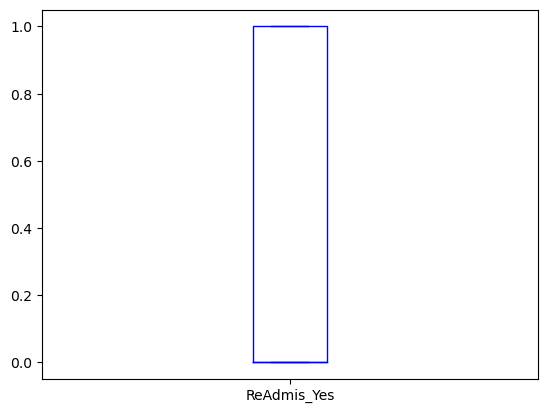

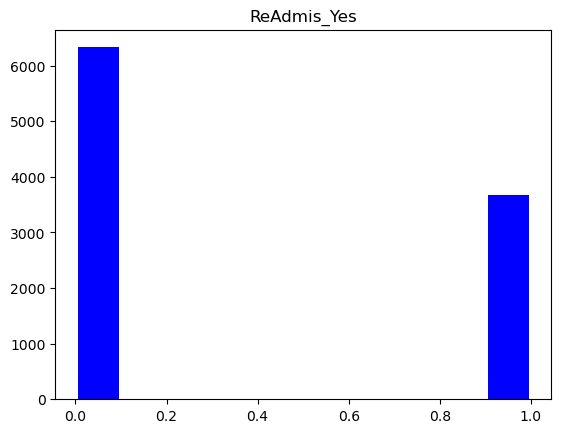

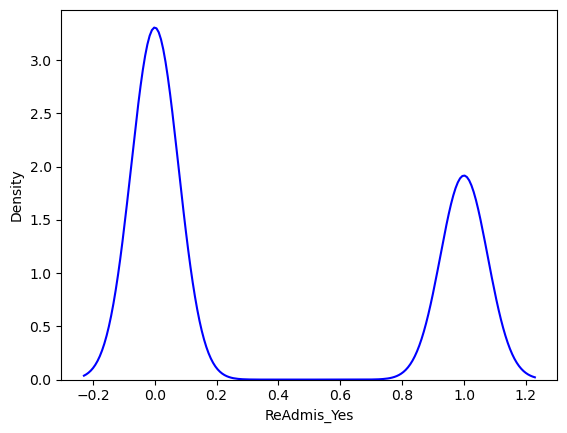

In [47]:
# Create boxplot for ReAdmis_Yes variable
plt.show(medical_df_prep.boxplot(column=['ReAdmis_Yes'], grid=False, color='blue'))
# Create histogram for ReAdmis_Yes variable
plt.show(medical_df_prep.hist(column='ReAdmis_Yes', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for ReAdmis_Yes variable
plt.show(sns.kdeplot(medical_df_prep['ReAdmis_Yes'], color='blue'))

Review univariate statistical analysis for Age variable and bivariate statistical analysis for Age and ReAdmis_Yes variables:

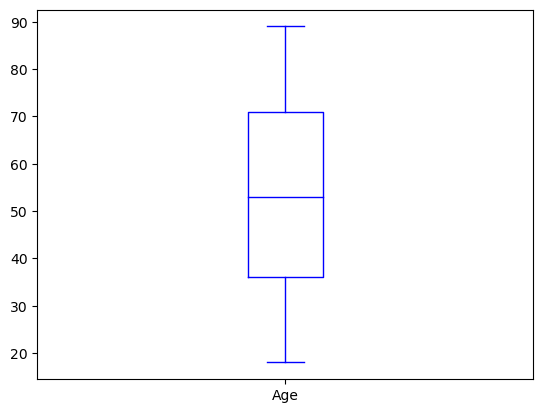

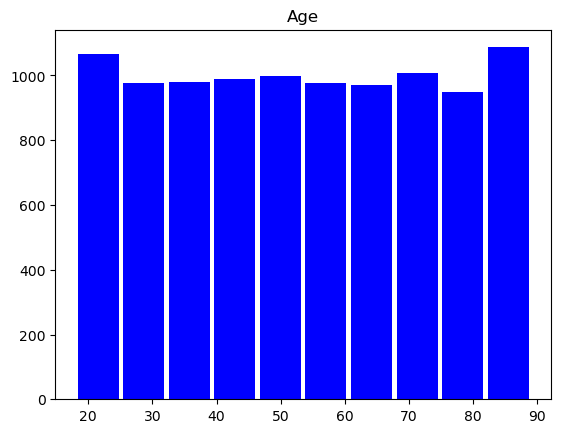

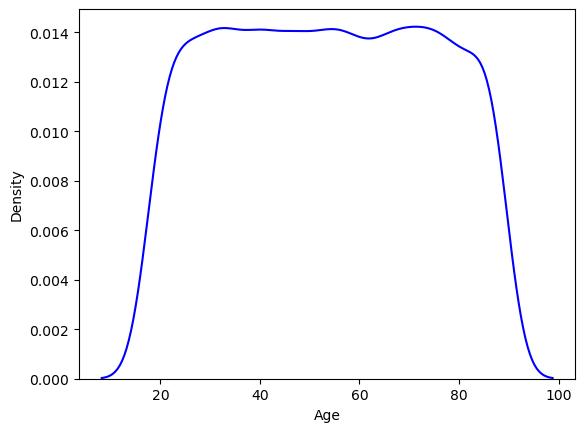

The correlation coefficient of Age and ReAdmis_Yes is 0.015810423462927072


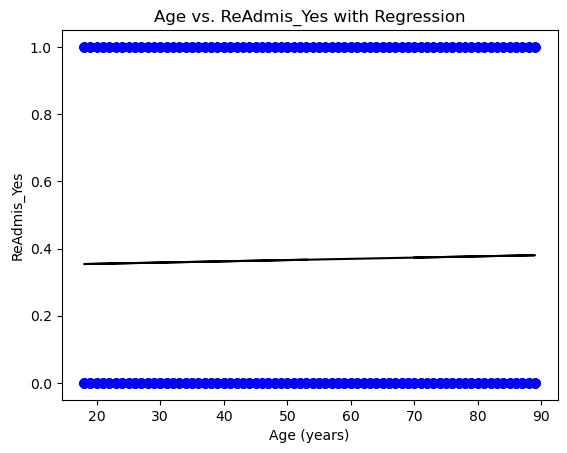

In [48]:
# Create boxplot for Age variable
plt.show(medical_df_prep.boxplot(column=['Age'], grid=False, color='blue'))
# Create histogram for Age variable
plt.show(medical_df_prep.hist(column='Age', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Age variable
plt.show(sns.kdeplot(medical_df_prep['Age'], color='blue'))

# Create a correlation matrix for Age and ReAdmis_Yes variables
corr_Age_ReAdmis_Yes = medical_df_prep['Age'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Age and ReAdmis_Yes is " + str(corr_Age_ReAdmis_Yes))
# Create a linear regression model and graph for Age and ReAdmis_Yes variables
Age_reg = np.array(medical_df_prep['Age'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Age_ReAdmis_Yes = LinearRegression().fit(Age_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Age_ReAdmis_Yes.predict(Age_reg.reshape(-1,1))
plt.scatter(Age_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Age_reg, ReAdmis_Yes_pred, color='black')
plt.title("Age vs. ReAdmis_Yes with Regression")
plt.xlabel("Age (years)")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univariate statistical analysis for VitD_levels variable and bivariate statistical analysis for VitD_levels and ReAdmis_Yes variables:

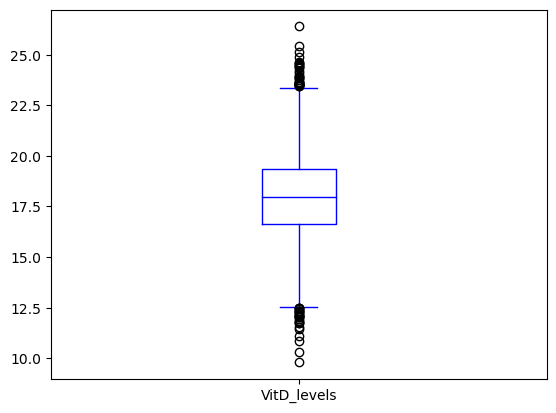

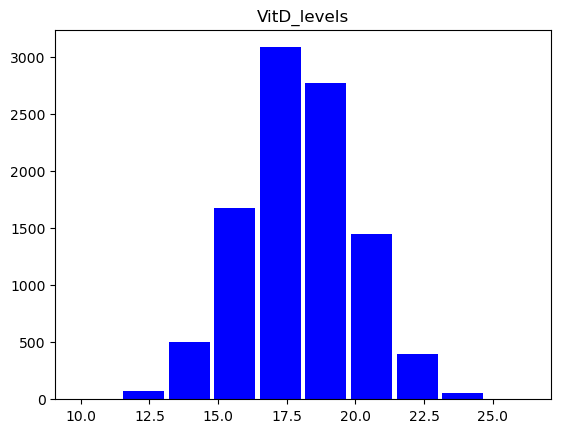

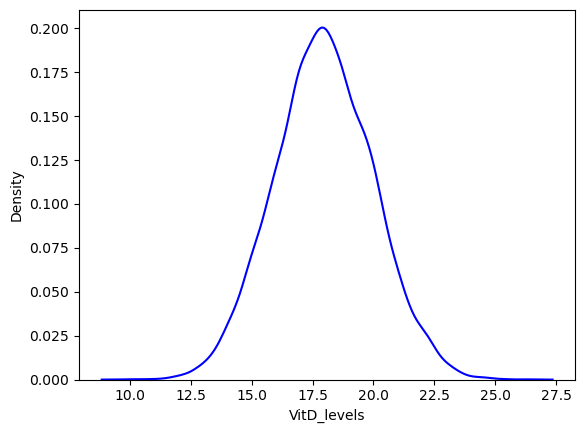

The correlation coefficient of VitD_levels and ReAdmis_Yes is 0.004082587790718849


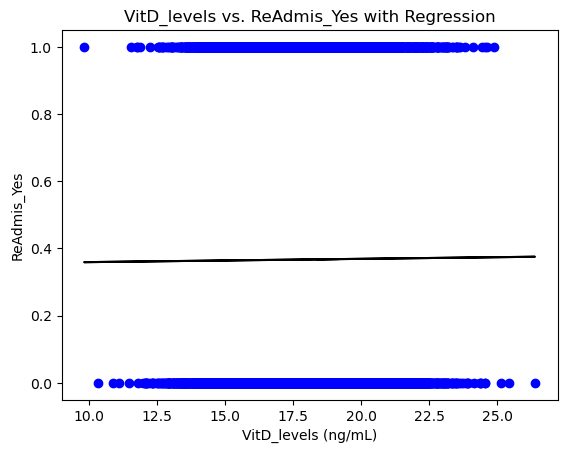

In [49]:
# Create boxplot for VitD_levels variable
plt.show(medical_df_prep.boxplot(column=['VitD_levels'], grid=False, color='blue'))
# Create histogram for VitD_levels variable
plt.show(medical_df_prep.hist(column='VitD_levels', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for VitD_levels variable
plt.show(sns.kdeplot(medical_df_prep['VitD_levels'], color='blue'))

# Create a correlation matrix for VitD_levels and ReAdmis_Yes variables
corr_VitD_levels_ReAdmis_Yes = medical_df_prep['VitD_levels'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of VitD_levels and ReAdmis_Yes is " + str(corr_VitD_levels_ReAdmis_Yes))
# Create a linear regression model and graph for VitD_levels and ReAdmis_Yes variables
VitD_levels_reg = np.array(medical_df_prep['VitD_levels'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_VitD_levels_ReAdmis_Yes = LinearRegression().fit(VitD_levels_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_VitD_levels_ReAdmis_Yes.predict(VitD_levels_reg.reshape(-1,1))
plt.scatter(VitD_levels_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(VitD_levels_reg, ReAdmis_Yes_pred, color='black')
plt.title("VitD_levels vs. ReAdmis_Yes with Regression")
plt.xlabel("VitD_levels (ng/mL)")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for Gender_Female variable and bivariate statistical analysis for Gender_Female and ReAdmis_Yes variables:

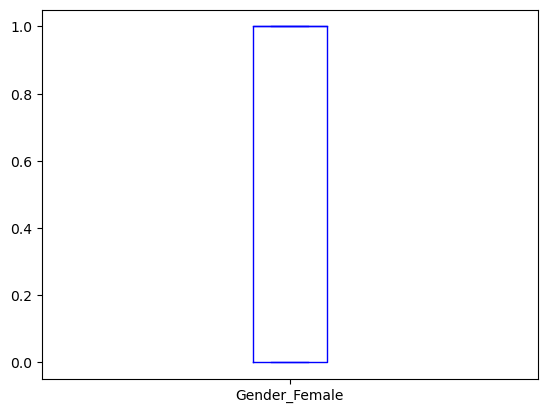

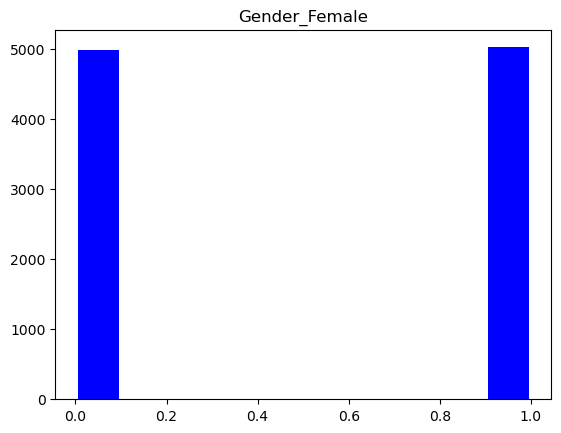

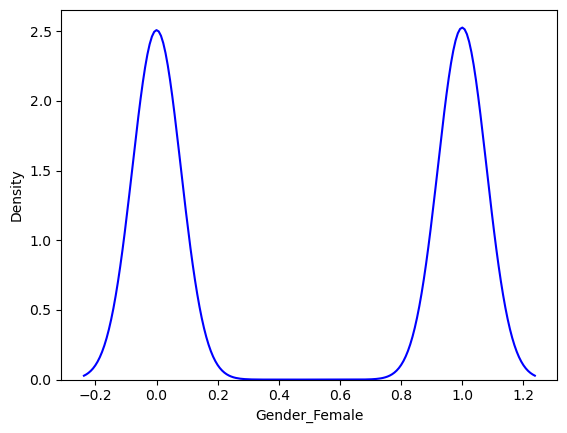

The correlation coefficient of Gender_Female and ReAdmis_Yes is -0.011662563587899936


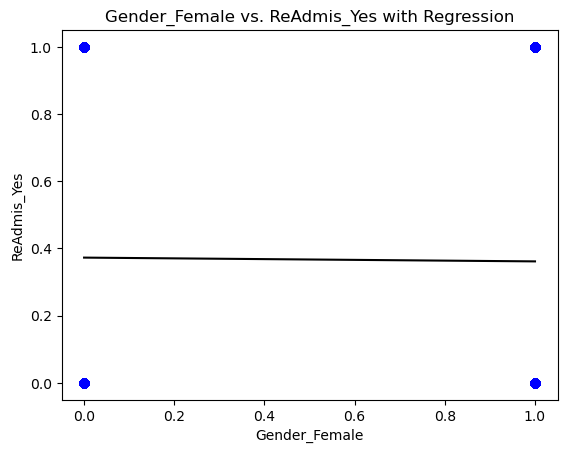

In [50]:
# Create boxplot for Gender_Female variable
plt.show(medical_df_prep.boxplot(column=['Gender_Female'], grid=False, color='blue'))
# Create histogram for Gender_Female variable
plt.show(medical_df_prep.hist(column='Gender_Female', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Gender_Female variable
plt.show(sns.kdeplot(medical_df_prep['Gender_Female'], color='blue'))

# Create a correlation matrix for Gender_Female and ReAdmis_Yes variables
corr_Gender_Female_ReAdmis_Yes = medical_df_prep['Gender_Female'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Gender_Female and ReAdmis_Yes is " + str(corr_Gender_Female_ReAdmis_Yes))
# Create a linear regression model and graph for Gender_Female and ReAdmis_Yes variables
Gender_Female_reg = np.array(medical_df_prep['Gender_Female'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Gender_Female_ReAdmis_Yes = LinearRegression().fit(Gender_Female_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Gender_Female_ReAdmis_Yes.predict(Gender_Female_reg.reshape(-1,1))
plt.scatter(Gender_Female_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Gender_Female_reg, ReAdmis_Yes_pred, color='black')
plt.title("Gender_Female vs. ReAdmis_Yes with Regression")
plt.xlabel("Gender_Female")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for Gender_Male variable and bivariate statistical analysis for Gender_Male and ReAdmis_Yes variables:

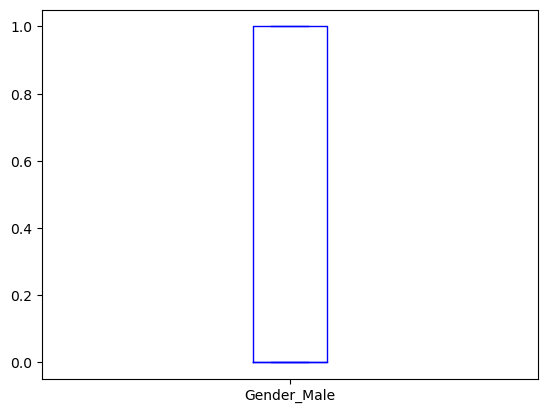

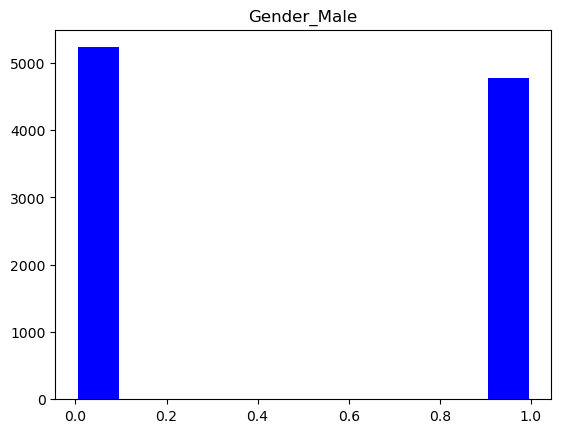

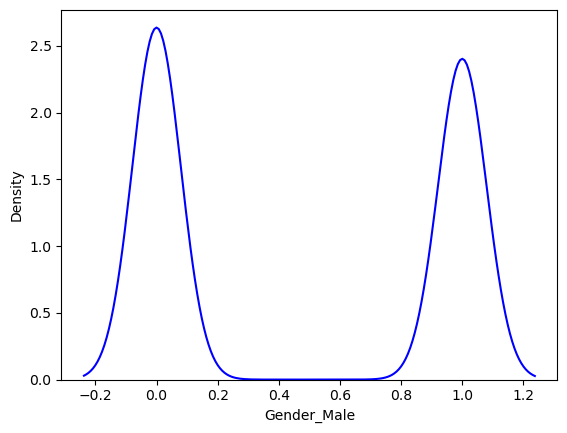

The correlation coefficient of Gender_Male and ReAdmis_Yes is 0.009812566178241838


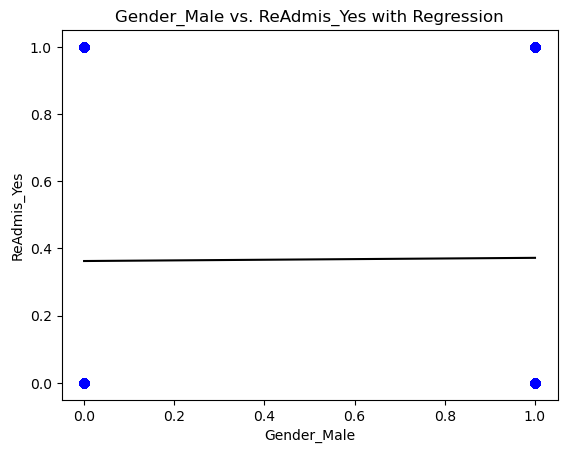

In [51]:
# Create boxplot for Gender_Male variable
plt.show(medical_df_prep.boxplot(column=['Gender_Male'], grid=False, color='blue'))
# Create histogram for Gender_Male variable
plt.show(medical_df_prep.hist(column='Gender_Male', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Gender_Male variable
plt.show(sns.kdeplot(medical_df_prep['Gender_Male'], color='blue'))

# Create a correlation matrix for Gender_Male and ReAdmis_Yes variables
corr_Gender_Male_ReAdmis_Yes = medical_df_prep['Gender_Male'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Gender_Male and ReAdmis_Yes is " + str(corr_Gender_Male_ReAdmis_Yes))
# Create a linear regression model and graph for Gender_Male and ReAdmis_Yes variables
Gender_Male_reg = np.array(medical_df_prep['Gender_Male'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Gender_Male_ReAdmis_Yes = LinearRegression().fit(Gender_Male_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Gender_Male_ReAdmis_Yes.predict(Gender_Male_reg.reshape(-1,1))
plt.scatter(Gender_Male_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Gender_Male_reg, ReAdmis_Yes_pred, color='black')
plt.title("Gender_Male vs. ReAdmis_Yes with Regression")
plt.xlabel("Gender_Male")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for Gender_Nonbinary variable and bivariate statistical analysis for Gender_Nonbinary and ReAdmis_Yes variables:

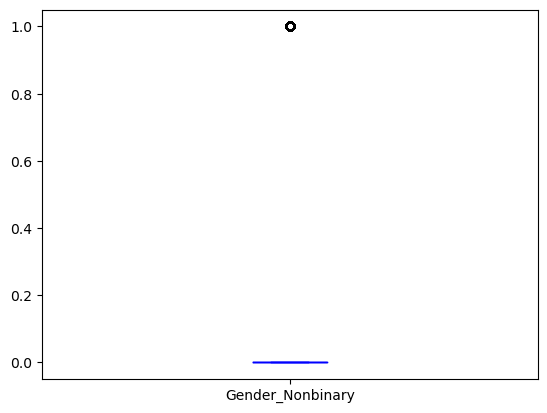

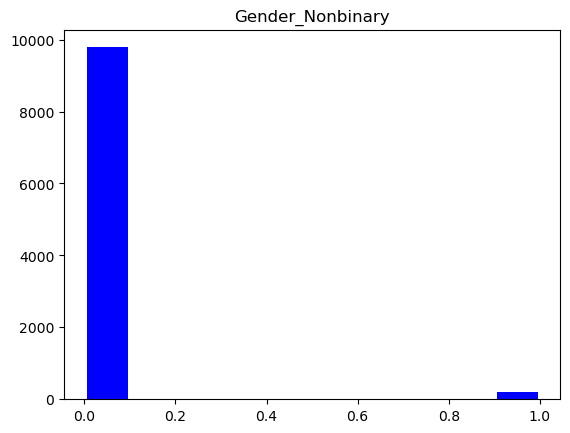

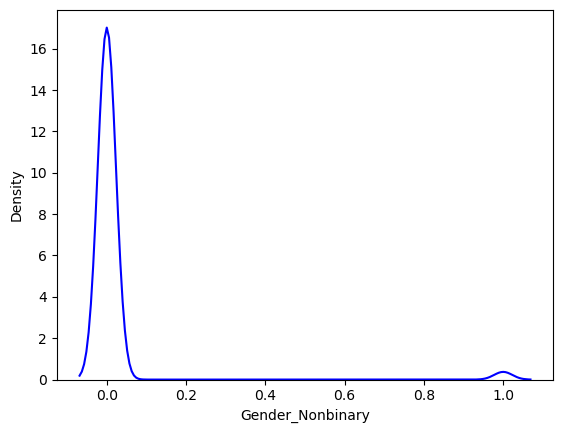

The correlation coefficient of Gender_Nonbinary and ReAdmis_Yes is 0.0064281793074185785


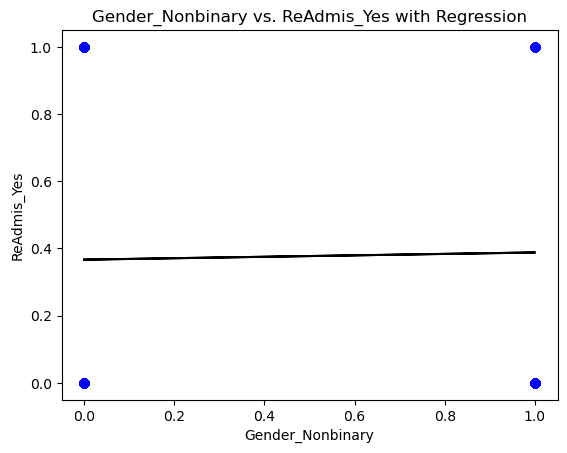

In [52]:
# Create boxplot for Gender_Nonbinary variable
plt.show(medical_df_prep.boxplot(column=['Gender_Nonbinary'], grid=False, color='blue'))
# Create histogram for Gender_Nonbinary variable
plt.show(medical_df_prep.hist(column='Gender_Nonbinary', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Gender_Nonbinary variable
plt.show(sns.kdeplot(medical_df_prep['Gender_Nonbinary'], color='blue'))

# Create a correlation matrix for Gender_Nonbinary and ReAdmis_Yes variables
corr_Gender_Nonbinary_ReAdmis_Yes = medical_df_prep['Gender_Nonbinary'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Gender_Nonbinary and ReAdmis_Yes is " + str(corr_Gender_Nonbinary_ReAdmis_Yes))
# Create a linear regression model and graph for Gender_Nonbinary and ReAdmis_Yes variables
Gender_Nonbinary_reg = np.array(medical_df_prep['Gender_Nonbinary'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Gender_Nonbinary_ReAdmis_Yes = LinearRegression().fit(Gender_Nonbinary_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Gender_Nonbinary_ReAdmis_Yes.predict(Gender_Nonbinary_reg.reshape(-1,1))
plt.scatter(Gender_Nonbinary_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Gender_Nonbinary_reg, ReAdmis_Yes_pred, color='black')
plt.title("Gender_Nonbinary vs. ReAdmis_Yes with Regression")
plt.xlabel("Gender_Nonbinary")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for Gender_Nonbinary variable and bivariate statistical analysis for Gender_Nonbinary and ReAdmis_Yes variables:

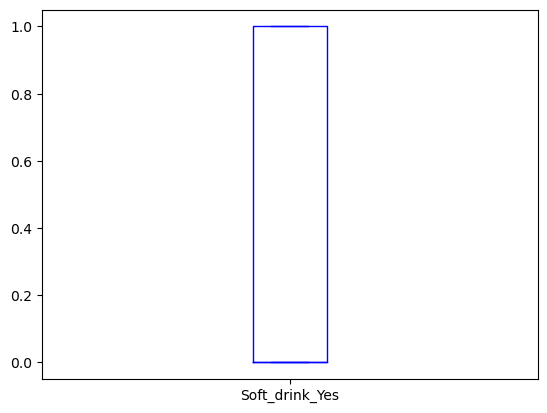

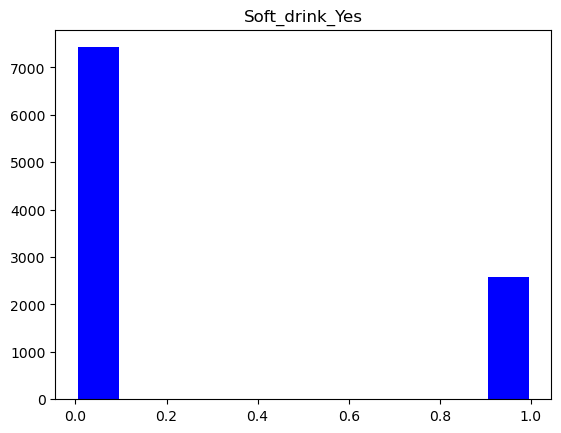

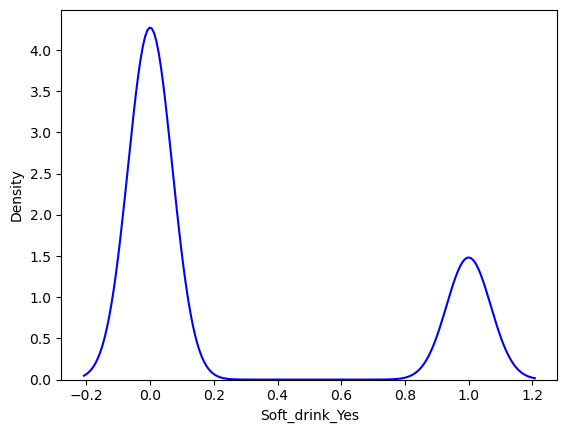

The correlation coefficient of Soft_drink_Yes and ReAdmis_Yes is 0.007702621423444896


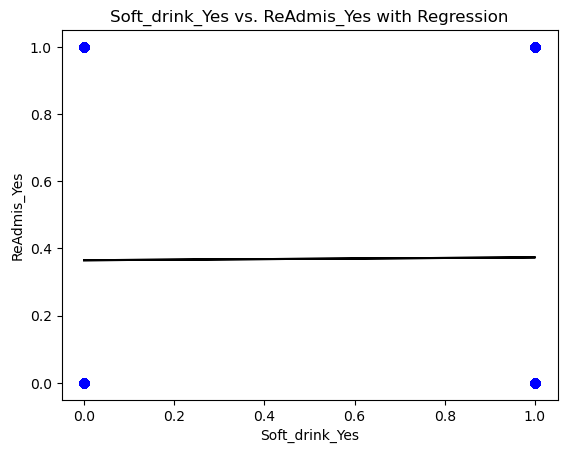

In [53]:
# Create boxplot for Soft_drink_Yes variable
plt.show(medical_df_prep.boxplot(column=['Soft_drink_Yes'], grid=False, color='blue'))
# Create histogram for Soft_drink_Yes variable
plt.show(medical_df_prep.hist(column='Soft_drink_Yes', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Soft_drink_Yes variable
plt.show(sns.kdeplot(medical_df_prep['Soft_drink_Yes'], color='blue'))

# Create a correlation matrix for Soft_drink_Yes and ReAdmis_Yes variables
corr_Soft_drink_Yes_ReAdmis_Yes = medical_df_prep['Soft_drink_Yes'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Soft_drink_Yes and ReAdmis_Yes is " + str(corr_Soft_drink_Yes_ReAdmis_Yes))
# Create a linear regression model and graph for Soft_drink_Yes and ReAdmis_Yes variables
Soft_drink_Yes_reg = np.array(medical_df_prep['Soft_drink_Yes'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Soft_drink_Yes_ReAdmis_Yes = LinearRegression().fit(Soft_drink_Yes_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Soft_drink_Yes_ReAdmis_Yes.predict(Soft_drink_Yes_reg.reshape(-1,1))
plt.scatter(Soft_drink_Yes_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Soft_drink_Yes_reg, ReAdmis_Yes_pred, color='black')
plt.title("Soft_drink_Yes vs. ReAdmis_Yes with Regression")
plt.xlabel("Soft_drink_Yes")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for Initial_admin_Elective variable and bivariate statistical analysis for Initial_admin_Elective and ReAdmis_Yes variables:

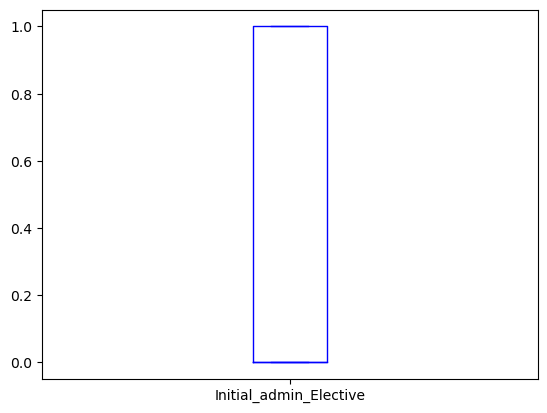

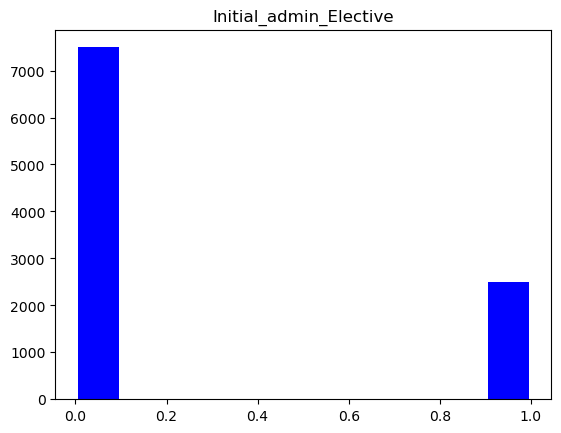

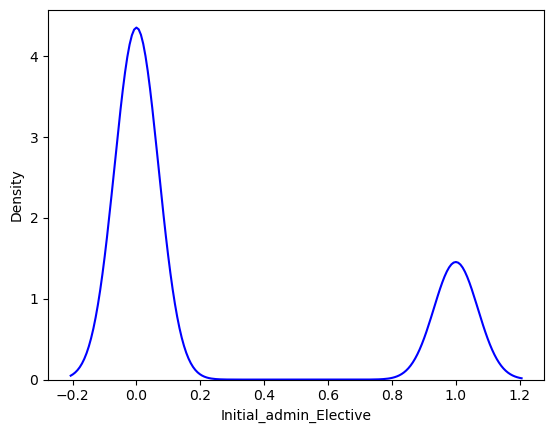

The correlation coefficient of Initial_admin_Elective and ReAdmis_Yes is -0.010879789294326658


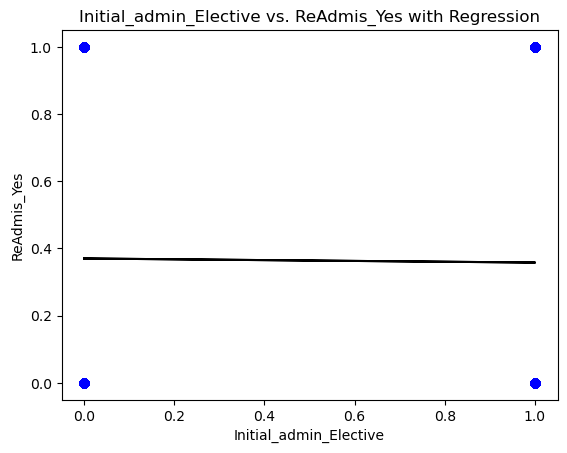

In [54]:
# Create boxplot for Initial_admin_Elective variable
plt.show(medical_df_prep.boxplot(column=['Initial_admin_Elective'], grid=False, color='blue'))
# Create histogram for Initial_admin_Elective variable
plt.show(medical_df_prep.hist(column='Initial_admin_Elective', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Initial_admin_Elective variable
plt.show(sns.kdeplot(medical_df_prep['Initial_admin_Elective'], color='blue'))

# Create a correlation matrix for Initial_admin_Elective and ReAdmis_Yes variables
corr_Initial_admin_Elective_ReAdmis_Yes = medical_df_prep['Initial_admin_Elective'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Initial_admin_Elective and ReAdmis_Yes is " + str(corr_Initial_admin_Elective_ReAdmis_Yes))
# Create a linear regression model and graph for Initial_admin_Elective and ReAdmis_Yes variables
Initial_admin_Elective_reg = np.array(medical_df_prep['Initial_admin_Elective'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Initial_admin_Elective_ReAdmis_Yes = LinearRegression().fit(Initial_admin_Elective_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Initial_admin_Elective_ReAdmis_Yes.predict(Initial_admin_Elective_reg.reshape(-1,1))
plt.scatter(Initial_admin_Elective_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Initial_admin_Elective_reg, ReAdmis_Yes_pred, color='black')
plt.title("Initial_admin_Elective vs. ReAdmis_Yes with Regression")
plt.xlabel("Initial_admin_Elective")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for Initial_admin_Emergency variable and bivariate statistical analysis for Initial_admin_Emergency and ReAdmis_Yes variables:

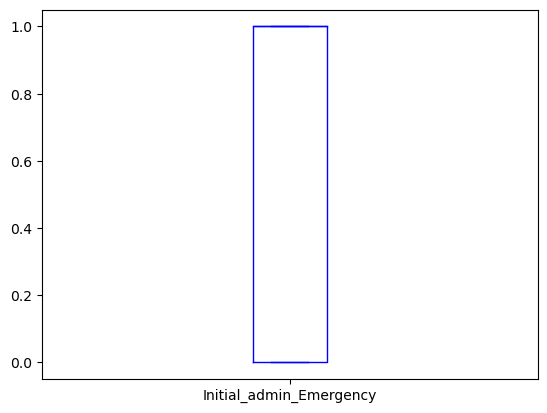

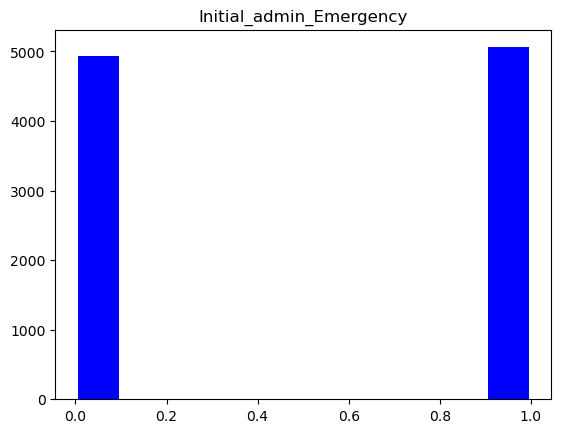

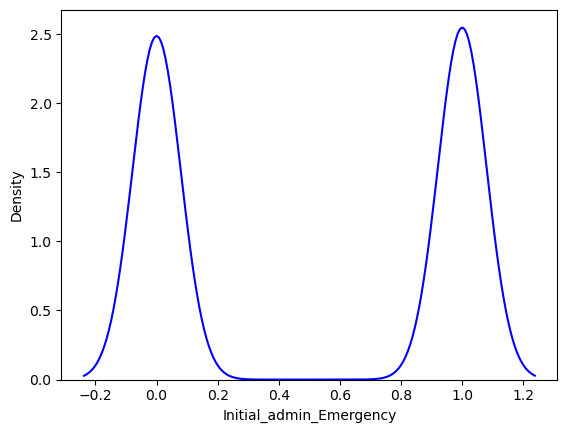

The correlation coefficient of Initial_admin_Emergency and ReAdmis_Yes is 0.019706833288422074


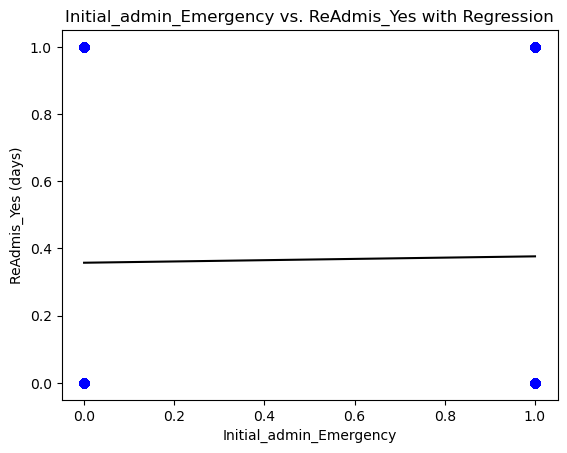

In [55]:
# Create boxplot for Initial_admin_Emergency variable
plt.show(medical_df_prep.boxplot(column=['Initial_admin_Emergency'], grid=False, color='blue'))
# Create histogram for Initial_admin_Emergency variable
plt.show(medical_df_prep.hist(column='Initial_admin_Emergency', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Initial_admin_Emergency variable
plt.show(sns.kdeplot(medical_df_prep['Initial_admin_Emergency'], color='blue'))

# Create a correlation matrix for Initial_admin_Emergency and ReAdmis_Yes variables
corr_Initial_admin_Emergency_ReAdmis_Yes = medical_df_prep['Initial_admin_Emergency'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Initial_admin_Emergency and ReAdmis_Yes is " + str(corr_Initial_admin_Emergency_ReAdmis_Yes))
# Create a linear regression model and graph for Initial_admin_Emergency and ReAdmis_Yes variables
Initial_admin_Emergency_reg = np.array(medical_df_prep['Initial_admin_Emergency'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Initial_admin_Emergency_ReAdmis_Yes = LinearRegression().fit(Initial_admin_Emergency_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Initial_admin_Emergency_ReAdmis_Yes.predict(Initial_admin_Emergency_reg.reshape(-1,1))
plt.scatter(Initial_admin_Emergency_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Initial_admin_Emergency_reg, ReAdmis_Yes_pred, color='black')
plt.title("Initial_admin_Emergency vs. ReAdmis_Yes with Regression")
plt.xlabel("Initial_admin_Emergency")
plt.ylabel("ReAdmis_Yes (days)")
plt.show()

Review univarate statistical analysis for Initial_admin_Observation variable and bivariate statistical analysis for Initial_admin_Observation and ReAdmis_Yes variables:

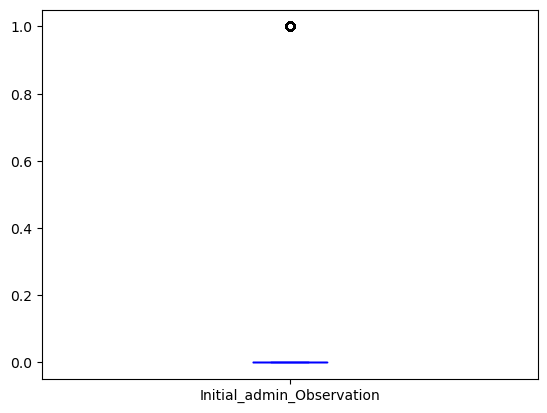

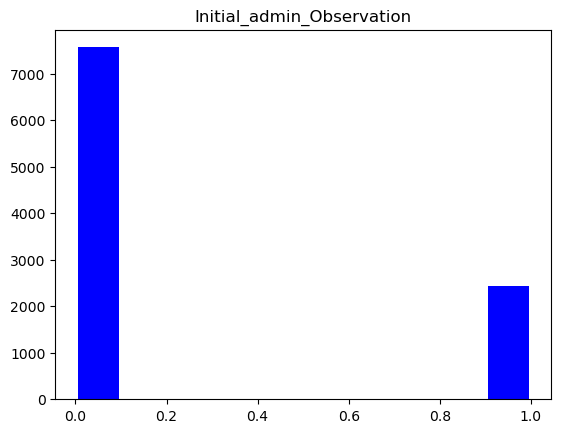

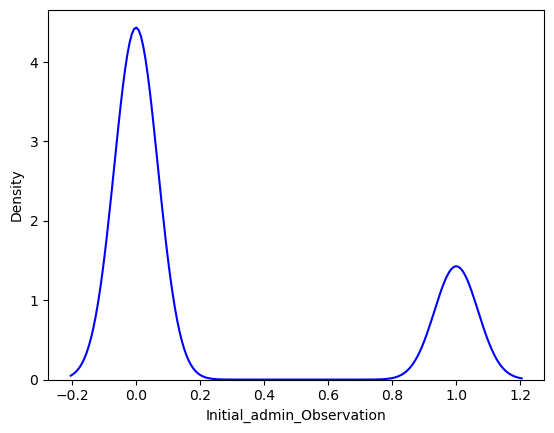

The correlation coefficient of Initial_admin_Observation and ReAdmis_Yes is -0.011972188277484329


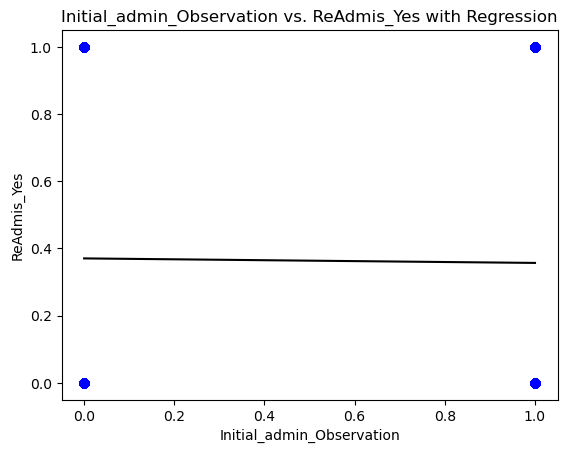

In [56]:

# Create boxplot for Initial_admin_Observation variable
plt.show(medical_df_prep.boxplot(column=['Initial_admin_Observation'], grid=False, color='blue'))
# Create histogram for Initial_admin_Observation variable
plt.show(medical_df_prep.hist(column='Initial_admin_Observation', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Initial_admin_Observation variable
plt.show(sns.kdeplot(medical_df_prep['Initial_admin_Observation'], color='blue'))

# Create a correlation matrix for Initial_admin_Observation and ReAdmis_Yes variables
corr_Initial_admin_Observation_ReAdmis_Yes = medical_df_prep['Initial_admin_Observation'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Initial_admin_Observation and ReAdmis_Yes is " + str(corr_Initial_admin_Observation_ReAdmis_Yes))
# Create a linear regression model and graph for Initial_admin_Observation and ReAdmis_Yes variables
Initial_admin_Observation_reg = np.array(medical_df_prep['Initial_admin_Observation'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Initial_admin_Observation_ReAdmis_Yes = LinearRegression().fit(Initial_admin_Observation_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Initial_admin_Observation_ReAdmis_Yes.predict(Initial_admin_Observation_reg.reshape(-1,1))
plt.scatter(Initial_admin_Observation_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Initial_admin_Observation_reg, ReAdmis_Yes_pred, color='black')
plt.title("Initial_admin_Observation vs. ReAdmis_Yes with Regression")
plt.xlabel("Initial_admin_Observation")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for HighBlood_Yes variable and bivariate statistical analysis for HighBlood_Yes and ReAdmis_Yes variables:

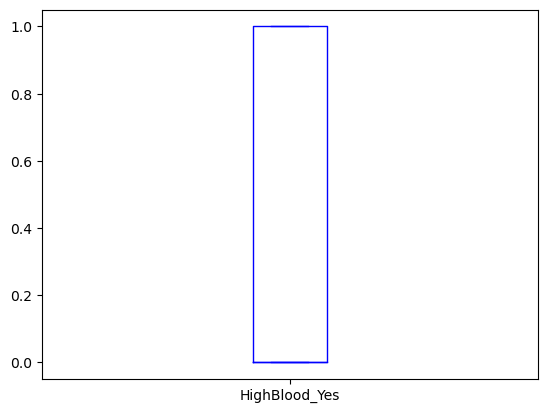

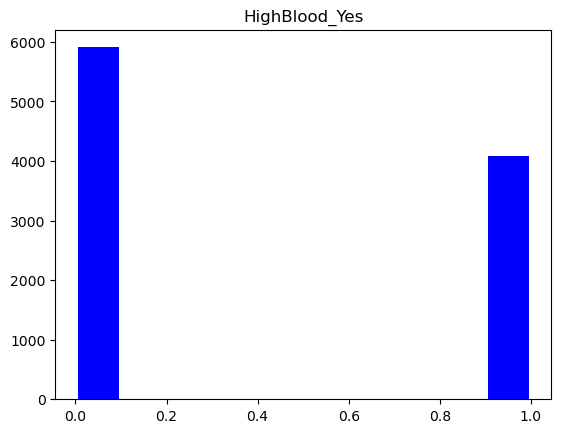

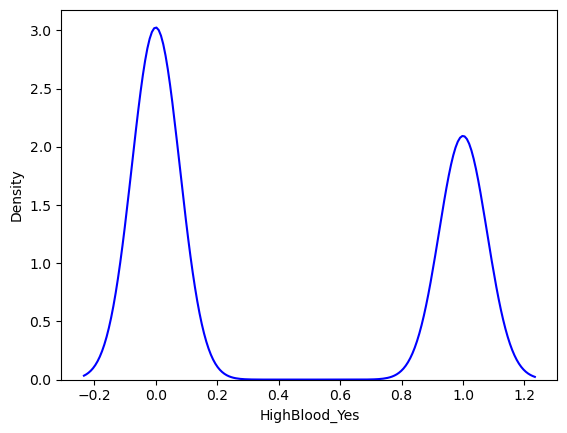

The correlation coefficient of HighBlood_Yes and ReAdmis_Yes is 0.002270053732870699


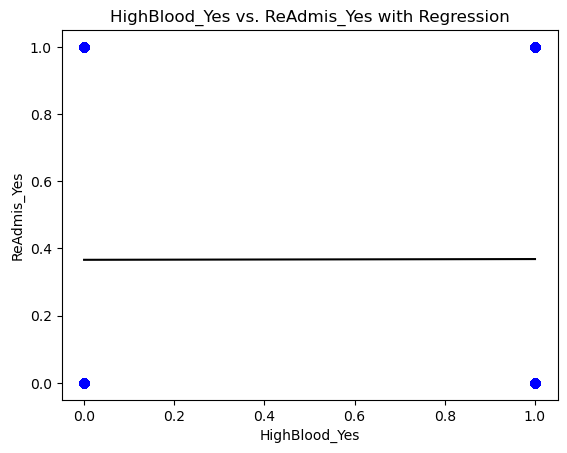

In [57]:
# Create boxplot for HighBlood_Yes variable
plt.show(medical_df_prep.boxplot(column=['HighBlood_Yes'], grid=False, color='blue'))
# Create histogram for HighBlood_Yes variable
plt.show(medical_df_prep.hist(column='HighBlood_Yes', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for HighBlood_Yes variable
plt.show(sns.kdeplot(medical_df_prep['HighBlood_Yes'], color='blue'))

# Create a correlation matrix for HighBlood_Yes and ReAdmis_Yes variables
corr_HighBlood_Yes_ReAdmis_Yes = medical_df_prep['HighBlood_Yes'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of HighBlood_Yes and ReAdmis_Yes is " + str(corr_HighBlood_Yes_ReAdmis_Yes))
# Create a linear regression model and graph for HighBlood_Yes and ReAdmis_Yes variables
HighBlood_Yes_reg = np.array(medical_df_prep['HighBlood_Yes'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_HighBlood_Yes_ReAdmis_Yes = LinearRegression().fit(HighBlood_Yes_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_HighBlood_Yes_ReAdmis_Yes.predict(HighBlood_Yes_reg.reshape(-1,1))
plt.scatter(HighBlood_Yes_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(HighBlood_Yes_reg, ReAdmis_Yes_pred, color='black')
plt.title("HighBlood_Yes vs. ReAdmis_Yes with Regression")
plt.xlabel("HighBlood_Yes")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for Stroke_Yes variable and bivariate statistical analysis for Stroke_Yes and ReAdmis_Yes variables:

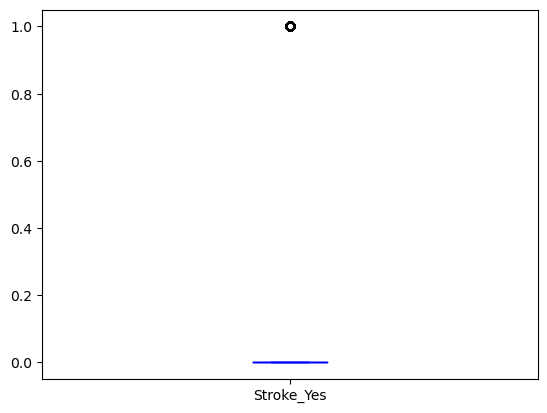

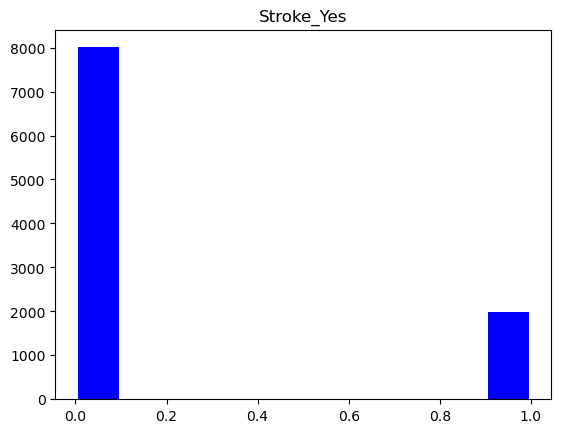

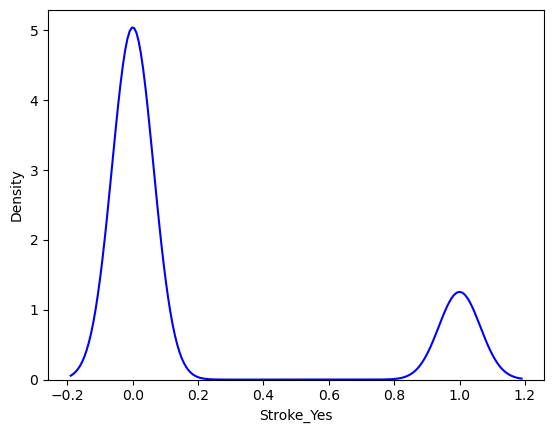

The correlation coefficient of Stroke_Yes and ReAdmis_Yes is 0.0009184539170457041


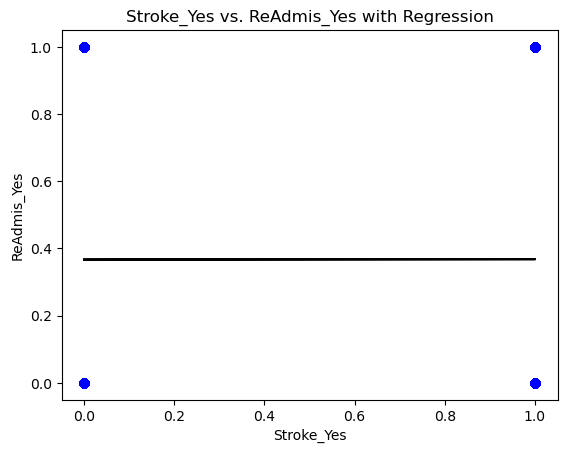

In [58]:
# Create boxplot for Stroke_Yes variable
plt.show(medical_df_prep.boxplot(column=['Stroke_Yes'], grid=False, color='blue'))
# Create histogram for Stroke_Yes variable
plt.show(medical_df_prep.hist(column='Stroke_Yes', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Stroke_Yes variable
plt.show(sns.kdeplot(medical_df_prep['Stroke_Yes'], color='blue'))

# Create a correlation matrix for Stroke_Yes and ReAdmis_Yes variables
corr_Stroke_Yes_ReAdmis_Yes = medical_df_prep['Stroke_Yes'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Stroke_Yes and ReAdmis_Yes is " + str(corr_Stroke_Yes_ReAdmis_Yes))
# Create a linear regression model and graph for Stroke_Yes and ReAdmis_Yes variables
Stroke_Yes_reg = np.array(medical_df_prep['Stroke_Yes'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Stroke_Yes_ReAdmis_Yes = LinearRegression().fit(Stroke_Yes_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Stroke_Yes_ReAdmis_Yes.predict(Stroke_Yes_reg.reshape(-1,1))
plt.scatter(Stroke_Yes_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Stroke_Yes_reg, ReAdmis_Yes_pred, color='black')
plt.title("Stroke_Yes vs. ReAdmis_Yes with Regression")
plt.xlabel("Stroke_Yes")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for Complication_risk_High variable and bivariate statistical analysis for Complication_risk_High and ReAdmis_Numeric variables:

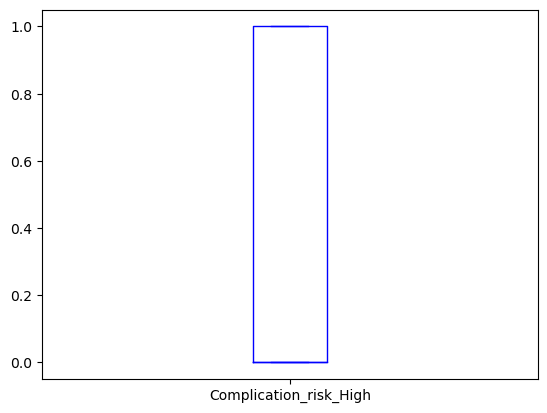

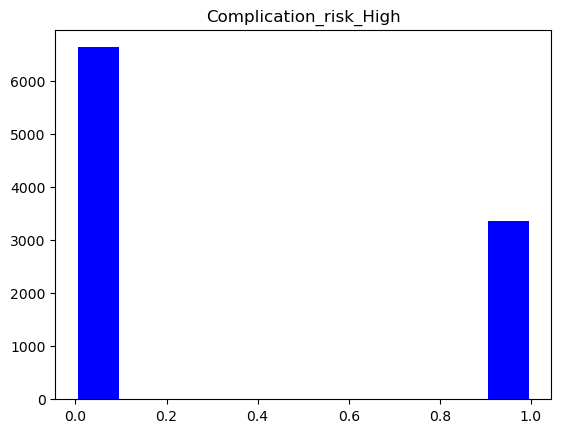

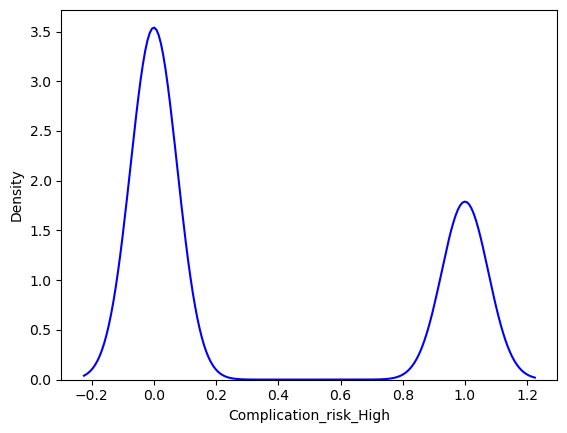

The correlation coefficient of Complication_risk_High and ReAdmis_Yes is -0.003976109925364818


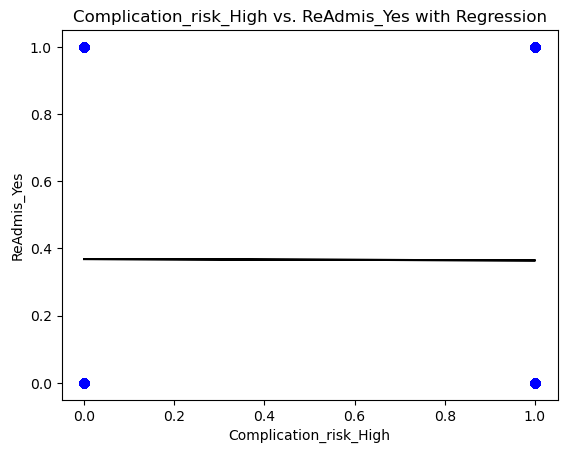

In [59]:
# Create boxplot for Complication_risk_High variable
plt.show(medical_df_prep.boxplot(column=['Complication_risk_High'], grid=False, color='blue'))
# Create histogram for Complication_risk_High variable
plt.show(medical_df_prep.hist(column='Complication_risk_High', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Complication_risk_High variable
plt.show(sns.kdeplot(medical_df_prep['Complication_risk_High'], color='blue'))

# Create a correlation matrix for Complication_risk_High and ReAdmis_Yes variables
corr_Complication_risk_High_ReAdmis_Yes = medical_df_prep['Complication_risk_High'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Complication_risk_High and ReAdmis_Yes is " + str(corr_Complication_risk_High_ReAdmis_Yes))
# Create a linear regression model and graph for Complication_risk_High and ReAdmis_Yes variables
Complication_risk_High_reg = np.array(medical_df_prep['Complication_risk_High'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Complication_risk_High_ReAdmis_Yes = LinearRegression().fit(Complication_risk_High_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Complication_risk_High_ReAdmis_Yes.predict(Complication_risk_High_reg.reshape(-1,1))
plt.scatter(Complication_risk_High_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Complication_risk_High_reg, ReAdmis_Yes_pred, color='black')
plt.title("Complication_risk_High vs. ReAdmis_Yes with Regression")
plt.xlabel("Complication_risk_High")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for Complication_risk_Medium variable and bivariate statistical analysis for Complication_risk_Medium and ReAdmis_Yes variables:

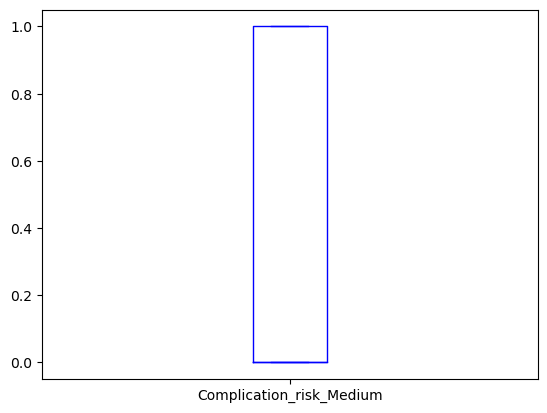

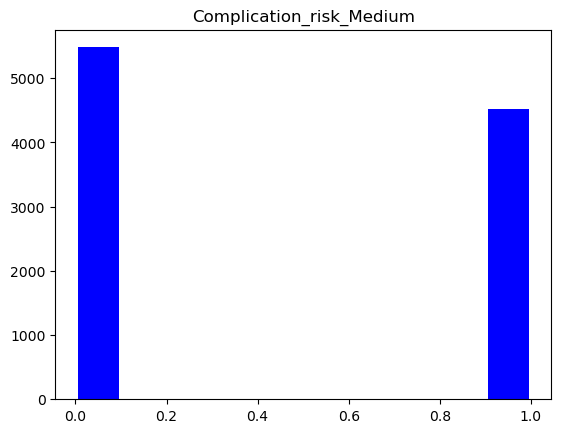

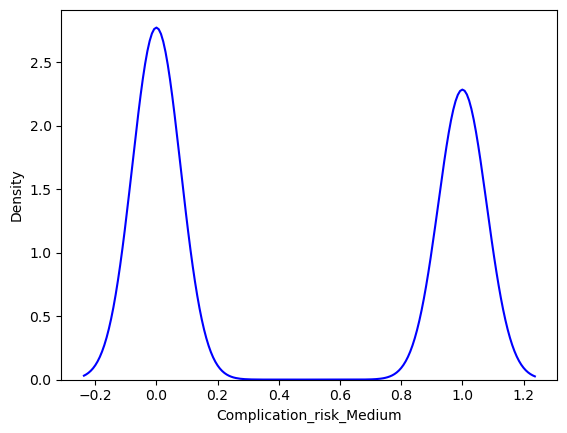

The correlation coefficient of Complication_risk_Medium and ReAdmis_Yes is 0.002798678796781504


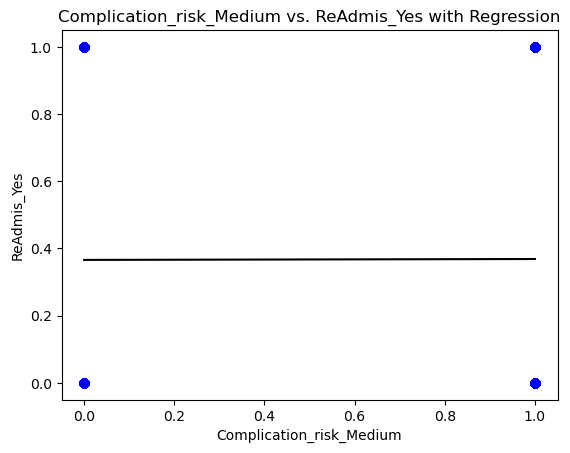

In [60]:
# Create boxplot for Complication_risk_Medium variable
plt.show(medical_df_prep.boxplot(column=['Complication_risk_Medium'], grid=False, color='blue'))
# Create histogram for Complication_risk_Medium variable
plt.show(medical_df_prep.hist(column='Complication_risk_Medium', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Complication_risk_Medium variable
plt.show(sns.kdeplot(medical_df_prep['Complication_risk_Medium'], color='blue'))

# Create a correlation matrix for Complication_risk_Medium and ReAdmis_Yes variables
corr_Complication_risk_Medium_ReAdmis_Yes = medical_df_prep['Complication_risk_Medium'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Complication_risk_Medium and ReAdmis_Yes is " + str(corr_Complication_risk_Medium_ReAdmis_Yes))
# Create a linear regression model and graph for Complication_risk_Medium and ReAdmis_Yes variables
Complication_risk_Medium_reg = np.array(medical_df_prep['Complication_risk_Medium'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Complication_risk_Medium_ReAdmis_Yes = LinearRegression().fit(Complication_risk_Medium_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Complication_risk_Medium_ReAdmis_Yes.predict(Complication_risk_Medium_reg.reshape(-1,1))
plt.scatter(Complication_risk_Medium_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Complication_risk_Medium_reg, ReAdmis_Yes_pred, color='black')
plt.title("Complication_risk_Medium vs. ReAdmis_Yes with Regression")
plt.xlabel("Complication_risk_Medium")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for Complication_risk_Low variable and bivariate statistical analysis for Complication_risk_Low and ReAdmis_Yes variables:

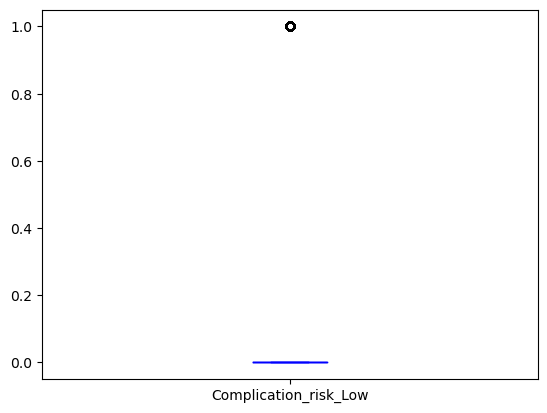

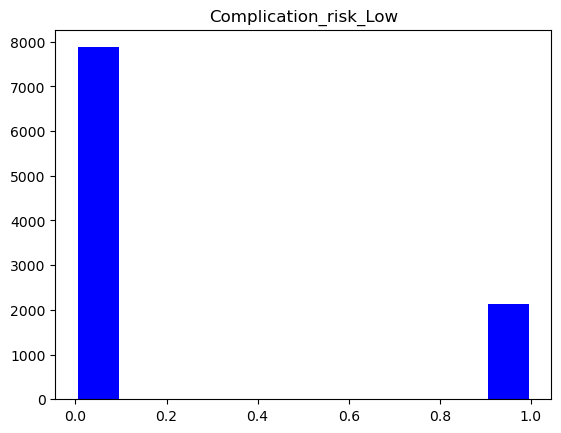

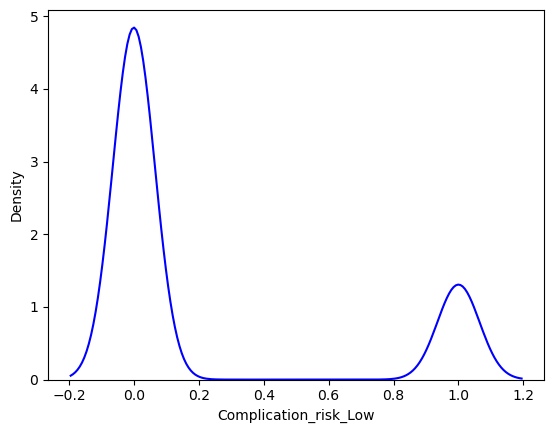

The correlation coefficient of Complication_risk_Low and ReAdmis_Yes is 0.0011855963633002333


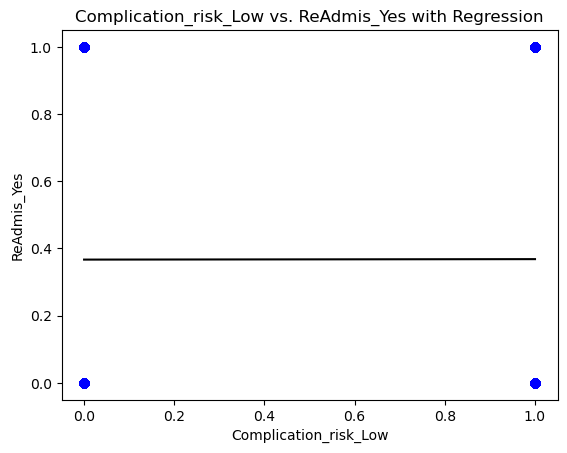

In [61]:
# Create boxplot for Complication_risk_Low variable
plt.show(medical_df_prep.boxplot(column=['Complication_risk_Low'], grid=False, color='blue'))
# Create histogram for Complication_risk_Low variable
plt.show(medical_df_prep.hist(column='Complication_risk_Low', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Complication_risk_Low variable
plt.show(sns.kdeplot(medical_df_prep['Complication_risk_Low'], color='blue'))

# Create a correlation matrix for Complication_risk_Low and ReAdmis_Yes variables
corr_Complication_risk_Low_ReAdmis_Yes = medical_df_prep['Complication_risk_Low'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Complication_risk_Low and ReAdmis_Yes is " + str(corr_Complication_risk_Low_ReAdmis_Yes))
# Create a linear regression model and graph for Complication_risk_Low and ReAdmis_Yes variables
Complication_risk_Low_reg = np.array(medical_df_prep['Complication_risk_Low'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Complication_risk_Low_ReAdmis_Yes = LinearRegression().fit(Complication_risk_Low_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Complication_risk_Low_ReAdmis_Yes.predict(Complication_risk_Low_reg.reshape(-1,1))
plt.scatter(Complication_risk_Low_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Complication_risk_Low_reg, ReAdmis_Yes_pred, color='black')
plt.title("Complication_risk_Low vs. ReAdmis_Yes with Regression")
plt.xlabel("Complication_risk_Low")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for Overweight_Yes variable and bivariate statistical analysis for Overweight_Yes and ReAdmis_Yes variables:

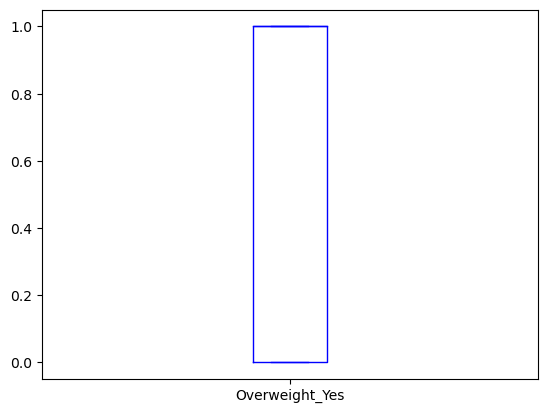

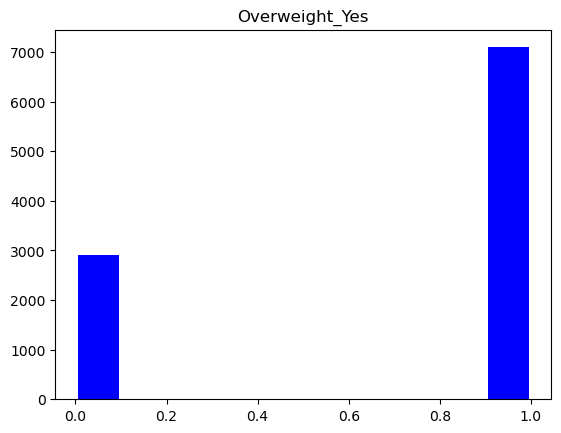

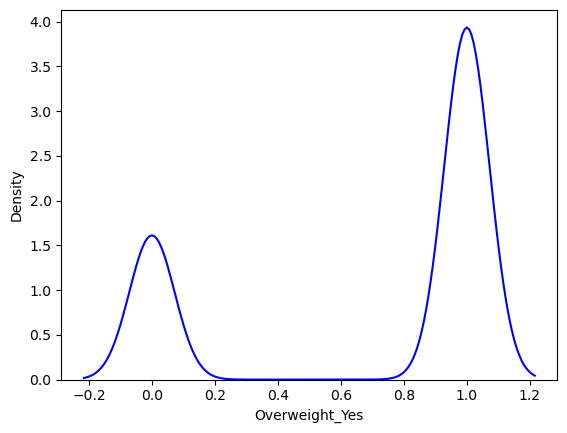

The correlation coefficient of Overweight_Yes and ReAdmis_Yes is -0.00858600250631413


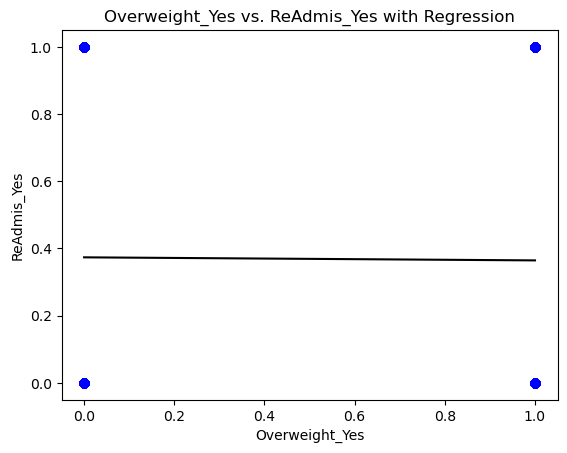

In [62]:
# Create boxplot for Overweight_Yes variable
plt.show(medical_df_prep.boxplot(column=['Overweight_Yes'], grid=False, color='blue'))
# Create histogram for Overweight_Yes variable
plt.show(medical_df_prep.hist(column='Overweight_Yes', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Overweight_Yes variable
plt.show(sns.kdeplot(medical_df_prep['Overweight_Yes'], color='blue'))

# Create a correlation matrix for Overweight_Yes and ReAdmis_Yes variables
corr_Overweight_Yes_ReAdmis_Yes = medical_df_prep['Overweight_Yes'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Overweight_Yes and ReAdmis_Yes is " + str(corr_Overweight_Yes_ReAdmis_Yes))
# Create a linear regression model and graph for Overweight_Yes and ReAdmis_Yes variables
Overweight_Yes_reg = np.array(medical_df_prep['Overweight_Yes'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Overweight_Yes_ReAdmis_Yes = LinearRegression().fit(Overweight_Yes_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Overweight_Yes_ReAdmis_Yes.predict(Overweight_Yes_reg.reshape(-1,1))
plt.scatter(Overweight_Yes_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Overweight_Yes_reg, ReAdmis_Yes_pred, color='black')
plt.title("Overweight_Yes vs. ReAdmis_Yes with Regression")
plt.xlabel("Overweight_Yes")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for Arthritis_Yes variable and bivariate statistical analysis for Arthritis_Yes and ReAdmis_Yes variables:

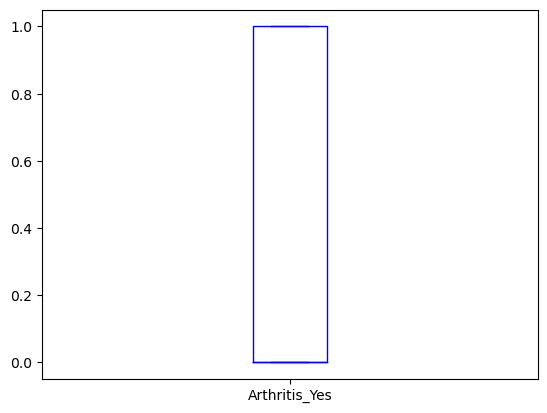

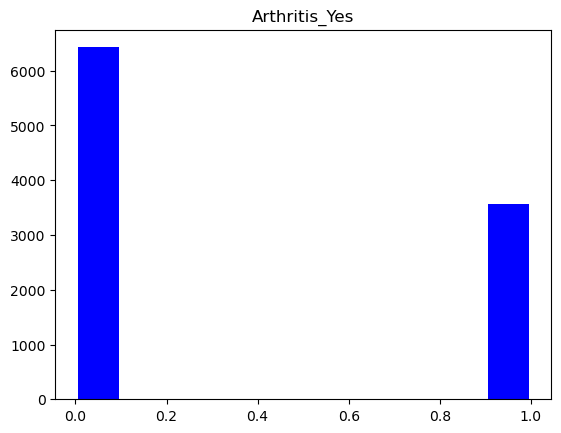

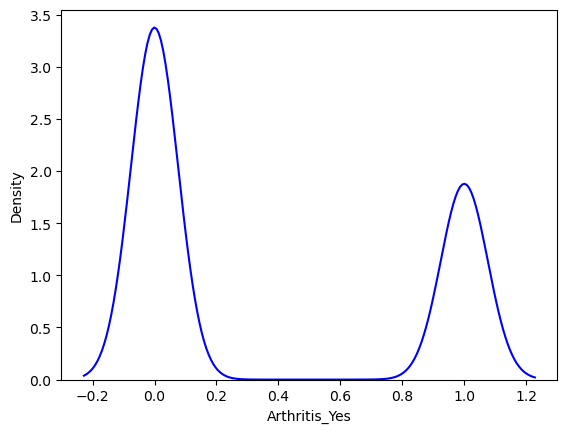

The correlation coefficient of Arthritis_Yes and ReAdmis_Yes is 0.007663036548941279


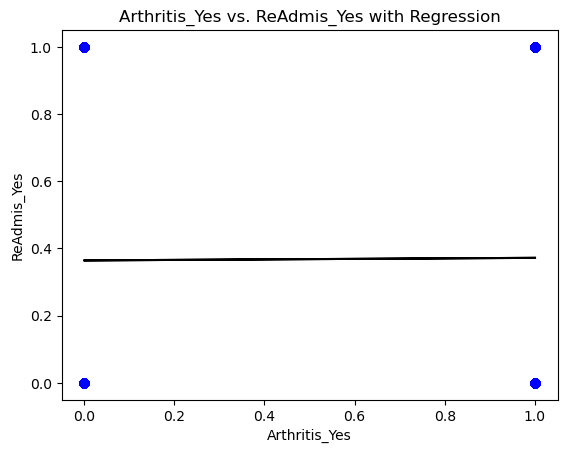

In [63]:
# Create boxplot for Arthritis_Yes variable
plt.show(medical_df_prep.boxplot(column=['Arthritis_Yes'], grid=False, color='blue'))
# Create histogram for Arthritis_Yes variable
plt.show(medical_df_prep.hist(column='Arthritis_Yes', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Arthritis_Yes variable
plt.show(sns.kdeplot(medical_df_prep['Arthritis_Yes'], color='blue'))

# Create a correlation matrix for Arthritis_Yes and ReAdmis_Yes variables
corr_Arthritis_Yes_ReAdmis_Yes = medical_df_prep['Arthritis_Yes'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Arthritis_Yes and ReAdmis_Yes is " + str(corr_Arthritis_Yes_ReAdmis_Yes))
# Create a linear regression model and graph for Arthritis_Yes and ReAdmis_Yes variables
Arthritis_Yes_reg = np.array(medical_df_prep['Arthritis_Yes'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Arthritis_Yes_ReAdmis_Yes = LinearRegression().fit(Arthritis_Yes_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Arthritis_Yes_ReAdmis_Yes.predict(Arthritis_Yes_reg.reshape(-1,1))
plt.scatter(Arthritis_Yes_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Arthritis_Yes_reg, ReAdmis_Yes_pred, color='black')
plt.title("Arthritis_Yes vs. ReAdmis_Yes with Regression")
plt.xlabel("Arthritis_Yes")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for Diabetes_Yes variable and bivariate statistical analysis for Diabetes_Yes and ReAdmis_Yes variables:

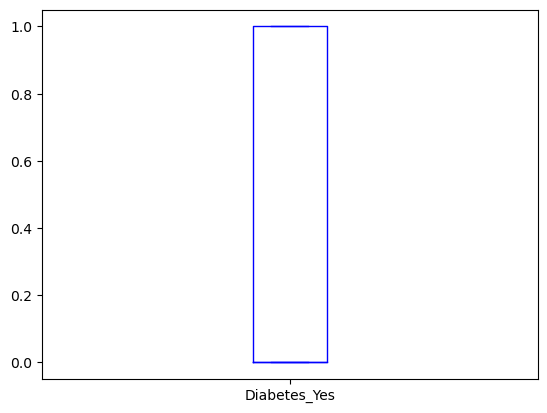

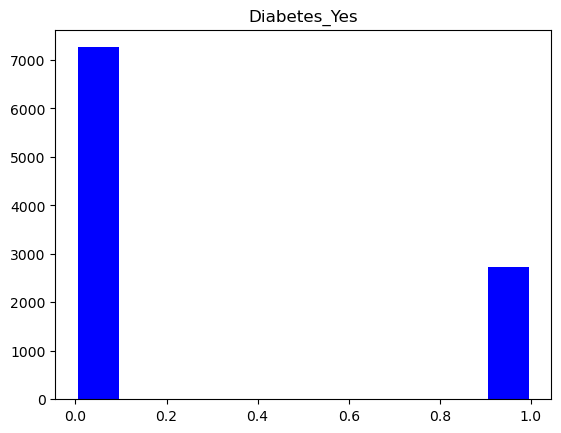

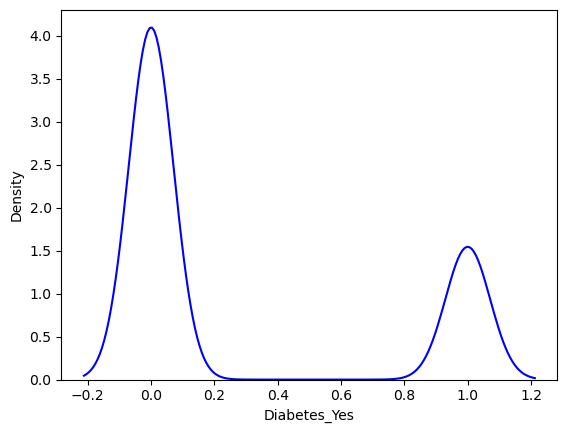

The correlation coefficient of Diabetes_Yes and ReAdmis_Yes is -0.0030581297963190404


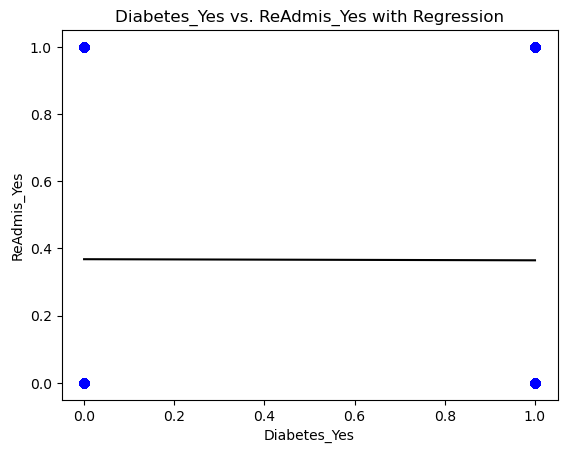

In [64]:
# Create boxplot for Diabetes_Yes variable
plt.show(medical_df_prep.boxplot(column=['Diabetes_Yes'], grid=False, color='blue'))
# Create histogram for Diabetes_Yes variable
plt.show(medical_df_prep.hist(column='Diabetes_Yes', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Diabetes_Yes variable
plt.show(sns.kdeplot(medical_df_prep['Diabetes_Yes'], color='blue'))

# Create a correlation matrix for Diabetes_Yes and ReAdmis_Yes variables
corr_Diabetes_Yes_ReAdmis_Yes = medical_df_prep['Diabetes_Yes'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Diabetes_Yes and ReAdmis_Yes is " + str(corr_Diabetes_Yes_ReAdmis_Yes))
# Create a linear regression model and graph for Diabetes_Yes and ReAdmis_Yes variables
Diabetes_Yes_reg = np.array(medical_df_prep['Diabetes_Yes'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Diabetes_Yes_ReAdmis_Yes = LinearRegression().fit(Diabetes_Yes_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Diabetes_Yes_ReAdmis_Yes.predict(Diabetes_Yes_reg.reshape(-1,1))
plt.scatter(Diabetes_Yes_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Diabetes_Yes_reg, ReAdmis_Yes_pred, color='black')
plt.title("Diabetes_Yes vs. ReAdmis_Yes with Regression")
plt.xlabel("Diabetes_Yes")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for Hyperlipidemia_Yes variable and bivariate statistical analysis for Hyperlipidemia_Yes and ReAdmis_Yes variables:

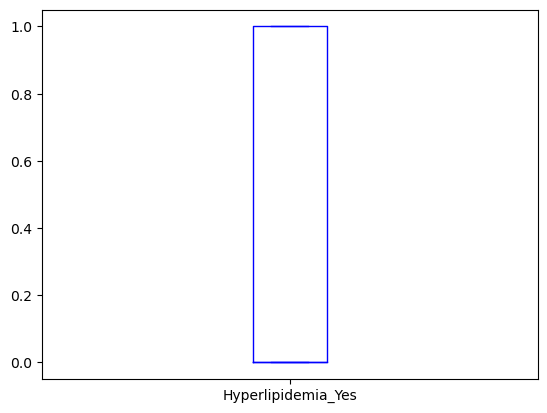

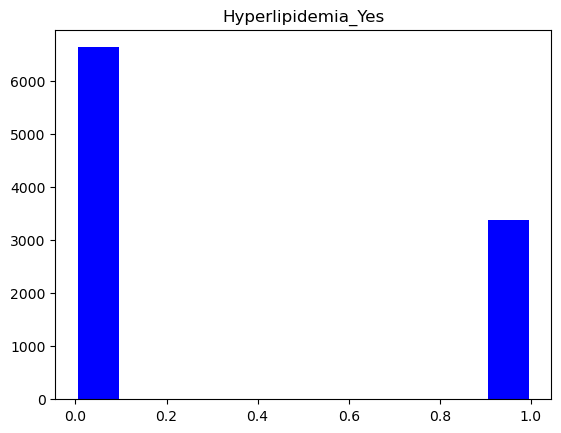

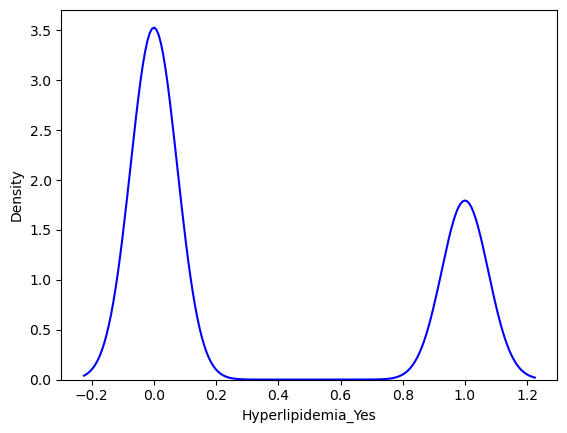

The correlation coefficient of Hyperlipidemia_Yes and ReAdmis_Yes is 0.004306908097121789


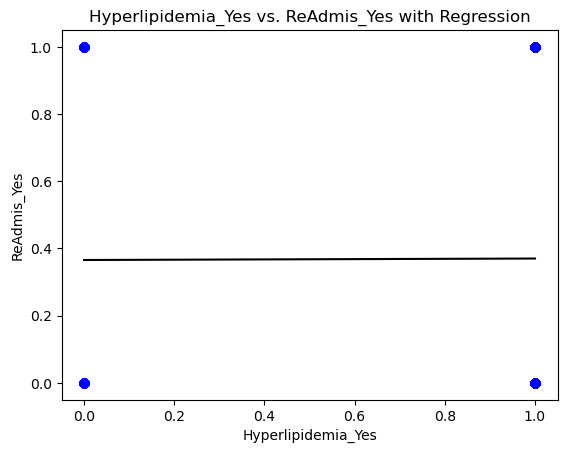

In [65]:
# Create boxplot for Hyperlipidemia_Yes variable
plt.show(medical_df_prep.boxplot(column=['Hyperlipidemia_Yes'], grid=False, color='blue'))
# Create histogram for Hyperlipidemia_Yes variable
plt.show(medical_df_prep.hist(column='Hyperlipidemia_Yes', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Hyperlipidemia_Yes variable
plt.show(sns.kdeplot(medical_df_prep['Hyperlipidemia_Yes'], color='blue'))

# Create a correlation matrix for Hyperlipidemia_Yes and ReAdmis_Yes variables
corr_Hyperlipidemia_Yes_ReAdmis_Yes = medical_df_prep['Hyperlipidemia_Yes'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Hyperlipidemia_Yes and ReAdmis_Yes is " + str(corr_Hyperlipidemia_Yes_ReAdmis_Yes))
# Create a linear regression model and graph for Hyperlipidemia_Yes and ReAdmis_Yes variables
Hyperlipidemia_Yes_reg = np.array(medical_df_prep['Hyperlipidemia_Yes'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Hyperlipidemia_Yes_ReAdmis_Yes = LinearRegression().fit(Hyperlipidemia_Yes_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Hyperlipidemia_Yes_ReAdmis_Yes.predict(Hyperlipidemia_Yes_reg.reshape(-1,1))
plt.scatter(Hyperlipidemia_Yes_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Hyperlipidemia_Yes_reg, ReAdmis_Yes_pred, color='black')
plt.title("Hyperlipidemia_Yes vs. ReAdmis_Yes with Regression")
plt.xlabel("Hyperlipidemia_Yes")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for BackPain_Yes variable and bivariate statistical analysis for BackPain_Yes and ReAdmis_Yes variables:

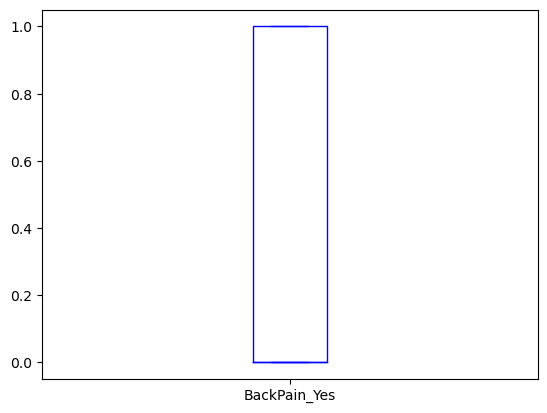

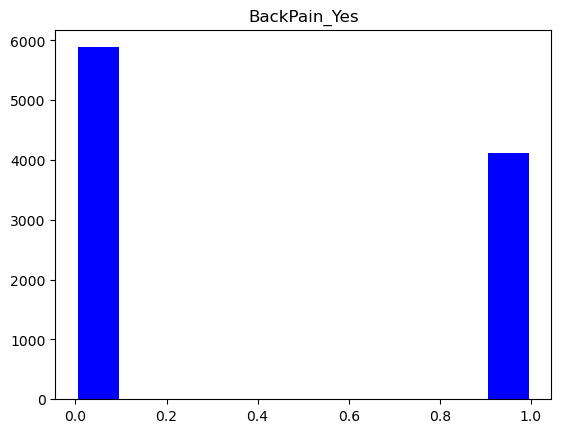

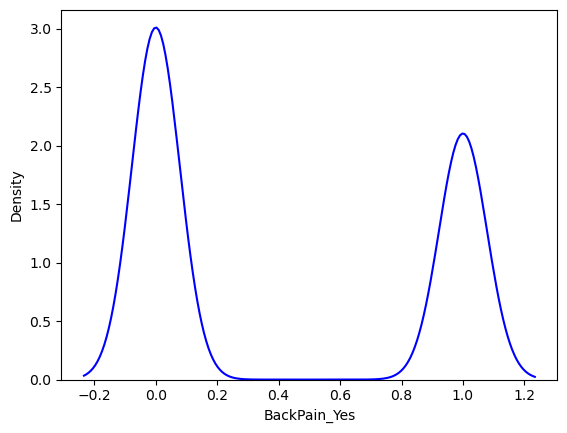

The correlation coefficient of BackPain_Yes and ReAdmis_Yes is 0.013312789543203456


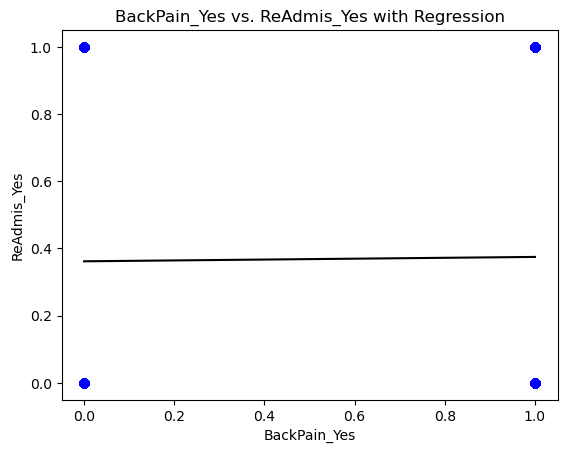

In [66]:
# Create boxplot for BackPain_Yes variable
plt.show(medical_df_prep.boxplot(column=['BackPain_Yes'], grid=False, color='blue'))
# Create histogram for BackPain_Yes variable
plt.show(medical_df_prep.hist(column='BackPain_Yes', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for BackPain_Yes variable
plt.show(sns.kdeplot(medical_df_prep['BackPain_Yes'], color='blue'))

# Create a correlation matrix for BackPain_Yes and ReAdmis_Yes variables
corr_BackPain_Yes_ReAdmis_Yes = medical_df_prep['BackPain_Yes'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of BackPain_Yes and ReAdmis_Yes is " + str(corr_BackPain_Yes_ReAdmis_Yes))
# Create a linear regression model and graph for BackPain_Yes and ReAdmis_Yes variables
BackPain_Yes_reg = np.array(medical_df_prep['BackPain_Yes'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_BackPain_Yes_ReAdmis_Yes = LinearRegression().fit(BackPain_Yes_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_BackPain_Yes_ReAdmis_Yes.predict(BackPain_Yes_reg.reshape(-1,1))
plt.scatter(BackPain_Yes_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(BackPain_Yes_reg, ReAdmis_Yes_pred, color='black')
plt.title("BackPain_Yes vs. ReAdmis_Yes with Regression")
plt.xlabel("BackPain_Yes")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for Anxiety_Yes variable and bivariate statistical analysis for Anxiety_Yes and ReAdmis_Yes variables:

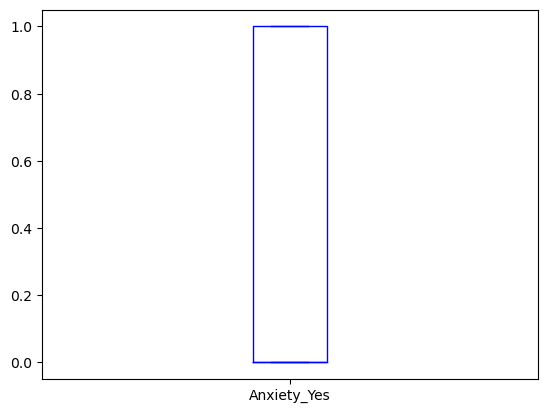

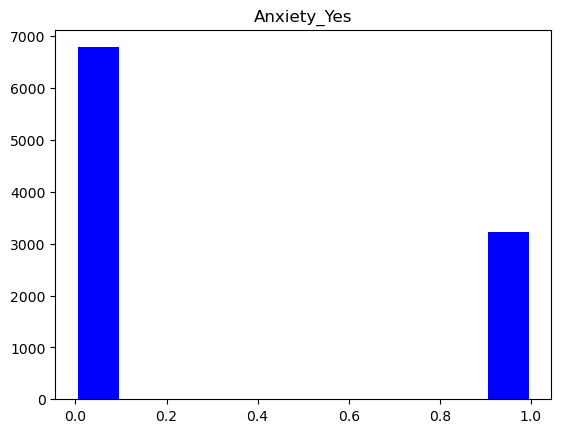

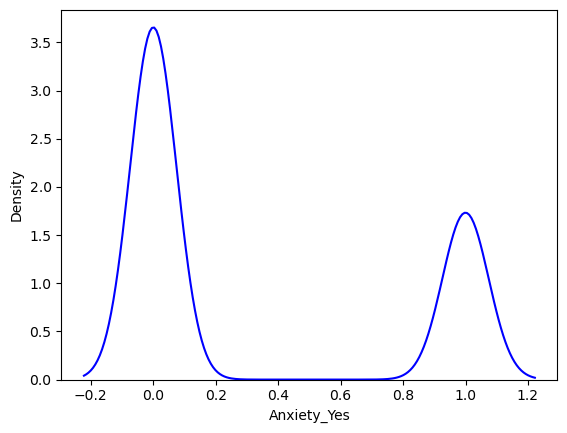

The correlation coefficient of Anxiety_Yes and ReAdmis_Yes is 0.002406264258006802


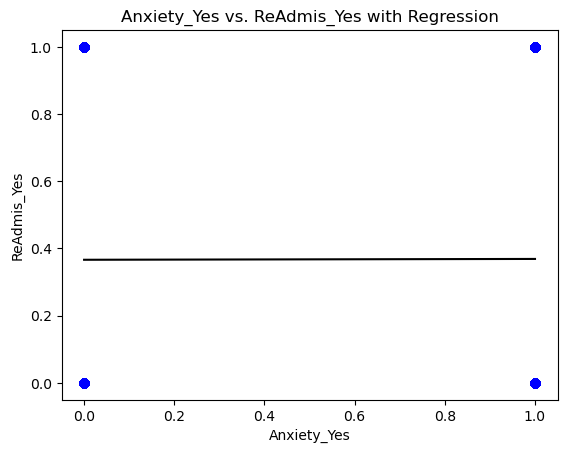

In [67]:
# Create boxplot for Anxiety_Yes variable
plt.show(medical_df_prep.boxplot(column=['Anxiety_Yes'], grid=False, color='blue'))
# Create histogram for Anxiety_Yes variable
plt.show(medical_df_prep.hist(column='Anxiety_Yes', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Anxiety_Yes variable
plt.show(sns.kdeplot(medical_df_prep['Anxiety_Yes'], color='blue'))

# Create a correlation matrix for Anxiety_Yes and ReAdmis_Yes variables
corr_Anxiety_Yes_ReAdmis_Yes = medical_df_prep['Anxiety_Yes'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Anxiety_Yes and ReAdmis_Yes is " + str(corr_Anxiety_Yes_ReAdmis_Yes))
# Create a linear regression model and graph for Anxiety_Yes and ReAdmis_Yes variables
Anxiety_Yes_reg = np.array(medical_df_prep['Anxiety_Yes'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Anxiety_Yes_ReAdmis_Yes = LinearRegression().fit(Anxiety_Yes_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Anxiety_Yes_ReAdmis_Yes.predict(Anxiety_Yes_reg.reshape(-1,1))
plt.scatter(Anxiety_Yes_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Anxiety_Yes_reg, ReAdmis_Yes_pred, color='black')
plt.title("Anxiety_Yes vs. ReAdmis_Yes with Regression")
plt.xlabel("Anxiety_Yes")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for Allergic_rhinitis_Yes variable and bivariate statistical analysis for Allergic_rhinitis_Yes and ReAdmis_Yes variables:

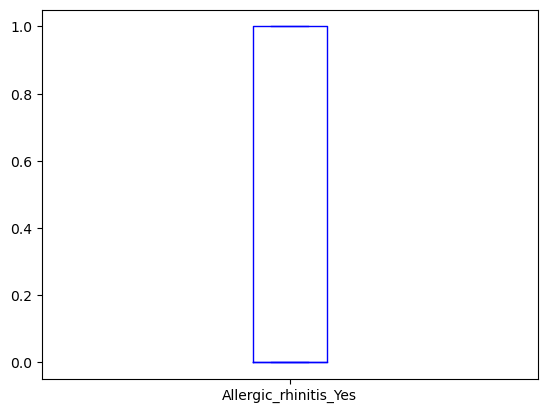

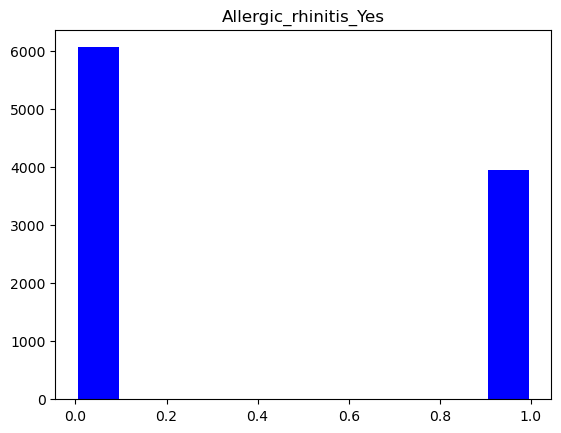

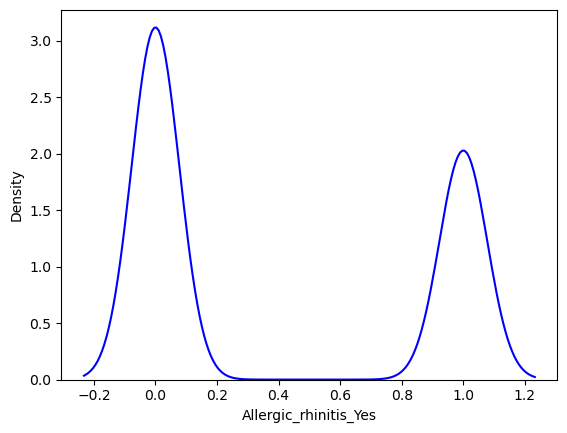

The correlation coefficient of Allergic_rhinitis_Yes and ReAdmis_Yes is -0.004650668844673674


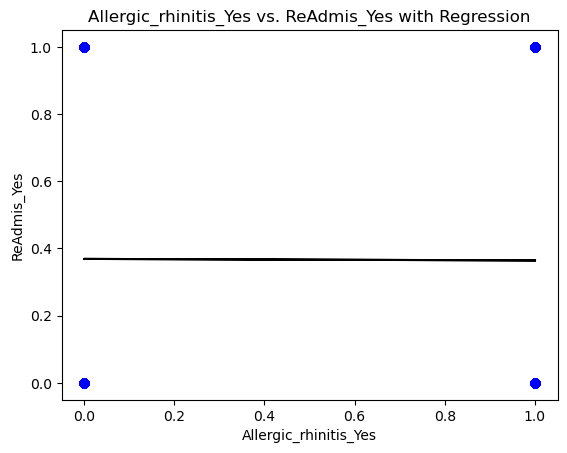

In [68]:
# Create boxplot for Allergic_rhinitis_Yes variable
plt.show(medical_df_prep.boxplot(column=['Allergic_rhinitis_Yes'], grid=False, color='blue'))
# Create histogram for Allergic_rhinitis_Yes variable
plt.show(medical_df_prep.hist(column='Allergic_rhinitis_Yes', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Allergic_rhinitis_Yes variable
plt.show(sns.kdeplot(medical_df_prep['Allergic_rhinitis_Yes'], color='blue'))

# Create a correlation matrix for Allergic_rhinitis_Yes and ReAdmis_Yes variables
corr_Allergic_rhinitis_Yes_ReAdmis_Yes = medical_df_prep['Allergic_rhinitis_Yes'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Allergic_rhinitis_Yes and ReAdmis_Yes is " + str(corr_Allergic_rhinitis_Yes_ReAdmis_Yes))
# Create a linear regression model and graph for Allergic_rhinitis_Yes and ReAdmis_Yes variables
Allergic_rhinitis_Yes_reg = np.array(medical_df_prep['Allergic_rhinitis_Yes'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Allergic_rhinitis_Yes_ReAdmis_Yes = LinearRegression().fit(Allergic_rhinitis_Yes_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Allergic_rhinitis_Yes_ReAdmis_Yes.predict(Allergic_rhinitis_Yes_reg.reshape(-1,1))
plt.scatter(Allergic_rhinitis_Yes_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Allergic_rhinitis_Yes_reg, ReAdmis_Yes_pred, color='black')
plt.title("Allergic_rhinitis_Yes vs. ReAdmis_Yes with Regression")
plt.xlabel("Allergic_rhinitis_Yes")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for Reflux_esophagitis_Yes variable and bivariate statistical analysis for Reflux_esophagitis_Yes and ReAdmis_Yes variables:

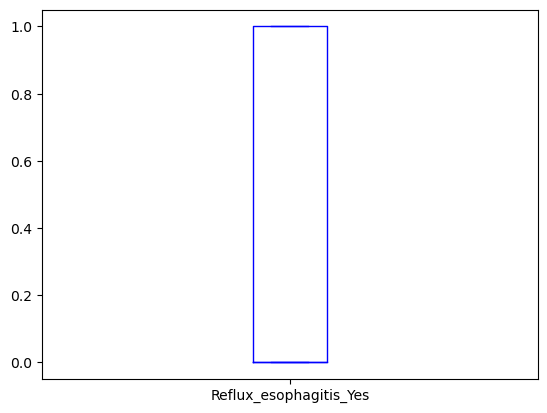

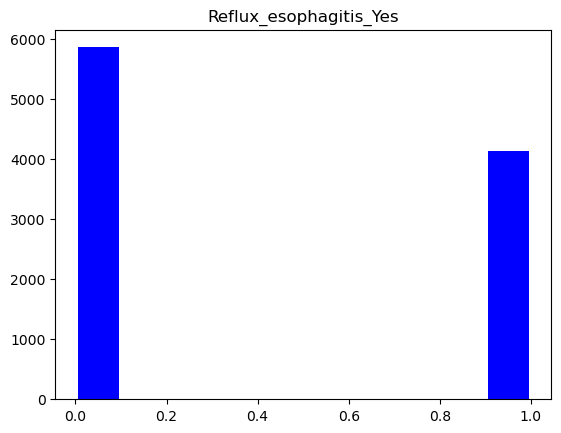

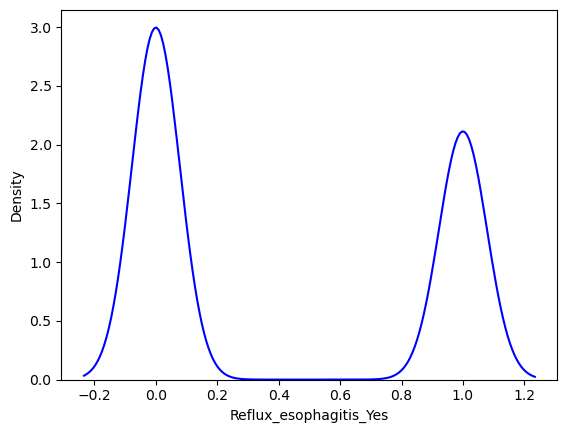

The correlation coefficient of Reflux_esophagitis_Yes and ReAdmis_Yes is 0.005421833156015592


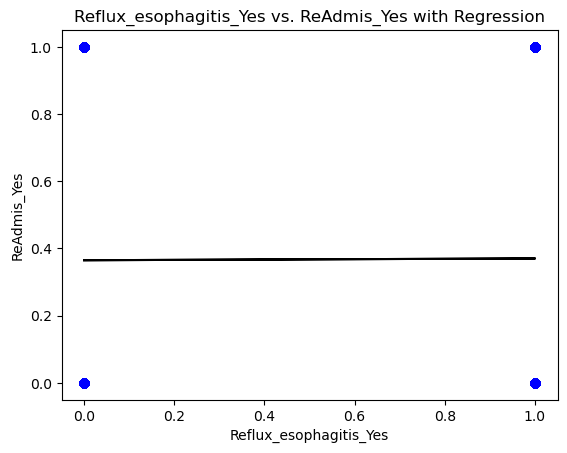

In [69]:
# Create boxplot for Reflux_esophagitis_Yes variable
plt.show(medical_df_prep.boxplot(column=['Reflux_esophagitis_Yes'], grid=False, color='blue'))
# Create histogram for Reflux_esophagitis_Yes variable
plt.show(medical_df_prep.hist(column='Reflux_esophagitis_Yes', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Reflux_esophagitis_Yes variable
plt.show(sns.kdeplot(medical_df_prep['Reflux_esophagitis_Yes'], color='blue'))

# Create a correlation matrix for Reflux_esophagitis_Yes and ReAdmis_Yes variables
corr_Reflux_esophagitis_Yes_ReAdmis_Yes = medical_df_prep['Reflux_esophagitis_Yes'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Reflux_esophagitis_Yes and ReAdmis_Yes is " + str(corr_Reflux_esophagitis_Yes_ReAdmis_Yes))
# Create a linear regression model and graph for Reflux_esophagitis_Yes and ReAdmis_Yes variables
Reflux_esophagitis_Yes_reg = np.array(medical_df_prep['Reflux_esophagitis_Yes'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Reflux_esophagitis_Yes_ReAdmis_Yes = LinearRegression().fit(Reflux_esophagitis_Yes_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Reflux_esophagitis_Yes_ReAdmis_Yes.predict(Reflux_esophagitis_Yes_reg.reshape(-1,1))
plt.scatter(Reflux_esophagitis_Yes_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Reflux_esophagitis_Yes_reg, ReAdmis_Yes_pred, color='black')
plt.title("Reflux_esophagitis_Yes vs. ReAdmis_Yes with Regression")
plt.xlabel("Reflux_esophagitis_Yes")
plt.ylabel("ReAdmis_Yes")
plt.show()

Review univarate statistical analysis for Asthma_Yes variable and bivariate statistical analysis for Asthma_Yes and ReAdmis_Yes variables:

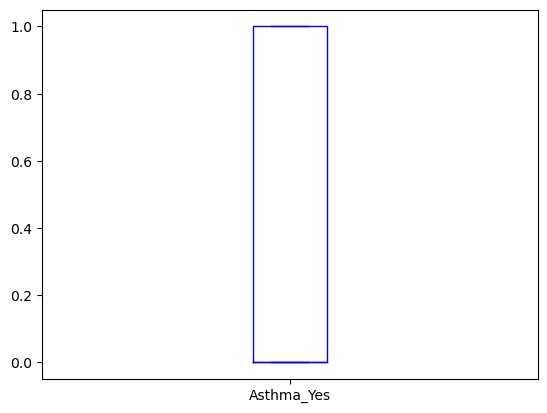

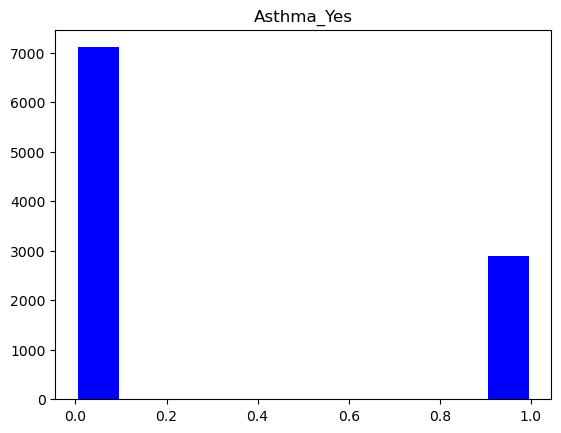

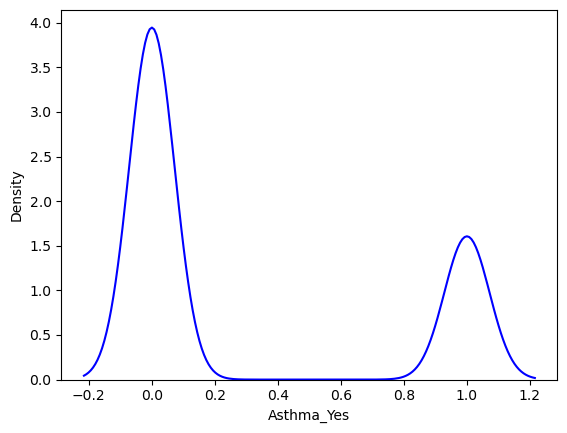

The correlation coefficient of Asthma_Yes and ReAdmis_Yes is -0.017132793168549713


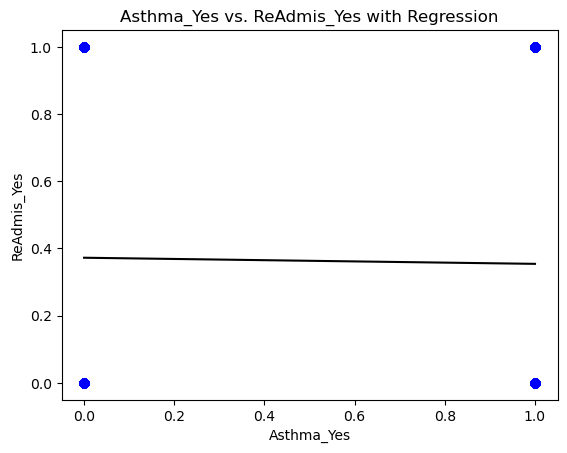

In [70]:
# Create boxplot for Asthma_Yes variable
plt.show(medical_df_prep.boxplot(column=['Asthma_Yes'], grid=False, color='blue'))
# Create histogram for Asthma_Yes variable
plt.show(medical_df_prep.hist(column='Asthma_Yes', bins=10, grid=False, rwidth=0.9, color='blue'))
# Create density plot for Asthma_Yes variable
plt.show(sns.kdeplot(medical_df_prep['Asthma_Yes'], color='blue'))

# Create a correlation matrix for Asthma_Yes and ReAdmis_Yes variables
corr_Asthma_Yes_ReAdmis_Yes = medical_df_prep['Asthma_Yes'].corr(medical_df_prep['ReAdmis_Yes'])
print("The correlation coefficient of Asthma_Yes and ReAdmis_Yes is " + str(corr_Asthma_Yes_ReAdmis_Yes))
# Create a linear regression model and graph for Asthma_Yes and ReAdmis_Yes variables
Asthma_Yes_reg = np.array(medical_df_prep['Asthma_Yes'])
ReAdmis_Yes_reg = np.array(medical_df_prep['ReAdmis_Yes'])
model_Asthma_Yes_ReAdmis_Yes = LinearRegression().fit(Asthma_Yes_reg.reshape(-1,1), ReAdmis_Yes_reg)
ReAdmis_Yes_pred = model_Asthma_Yes_ReAdmis_Yes.predict(Asthma_Yes_reg.reshape(-1,1))
plt.scatter(Asthma_Yes_reg, ReAdmis_Yes_reg, color='blue')
plt.plot(Asthma_Yes_reg, ReAdmis_Yes_pred, color='black')
plt.title("Asthma_Yes vs. ReAdmis_Yes with Regression")
plt.xlabel("Asthma_Yes")
plt.ylabel("ReAdmis_Yes")
plt.show()

# Export data set:

Export the cleaned and prepared data set as a .csv file:

In [71]:
medical_df_prep.to_csv('medical_df_prep.csv')

# Create Initial Model:

Review variables to be used for multicollinearity:

In [72]:
y, X = dmatrices('Initial_days ~ Age+VitD_levels+Gender_Female+Gender_Male+Gender_Nonbinary+Soft_drink_Yes+Initial_admin_Elective+Initial_admin_Emergency+Initial_admin_Observation+HighBlood_Yes+Stroke_Yes+Complication_risk_High+Complication_risk_Medium+Complication_risk_Low+Overweight_Yes+Arthritis_Yes+Diabetes_Yes+Hyperlipidemia_Yes+BackPain_Yes+Anxiety_Yes+Allergic_rhinitis_Yes+Reflux_esophagitis_Yes+Asthma_Yes', data = medical_df_prep, return_type='dataframe')

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns

vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]

print(vif_df)

                     variable       VIF
0                   Intercept  0.000000
1                         Age  1.002094
2                 VitD_levels  1.002604
3               Gender_Female       inf
4                 Gender_Male       inf
5            Gender_Nonbinary       inf
6              Soft_drink_Yes  1.002384
7      Initial_admin_Elective       inf
8     Initial_admin_Emergency       inf
9   Initial_admin_Observation       inf
10              HighBlood_Yes  1.002353
11                 Stroke_Yes  1.001213
12     Complication_risk_High       inf
13   Complication_risk_Medium       inf
14      Complication_risk_Low       inf
15             Overweight_Yes  1.002052
16              Arthritis_Yes  1.002255
17               Diabetes_Yes  1.002041
18         Hyperlipidemia_Yes  1.002203
19               BackPain_Yes  1.003203
20                Anxiety_Yes  1.001537
21      Allergic_rhinitis_Yes  1.001994
22     Reflux_esophagitis_Yes  1.002130
23                 Asthma_Yes  1.001386


C:\Users\chris\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\chris\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


The majority of VIF values found are close to 1 so they don't appear to be correlated. The variables that have been split into more than 2 dummy values are showing perfect correlation with an INF (infinite) VIF value. The "extra" two variables will be removed based on the percentage of results in each. The highest percentage answer will stay in the model while the lower two will be removed.

In [73]:
y, X = dmatrices('Initial_days ~ Age+VitD_levels+Gender_Female+Soft_drink_Yes+Initial_admin_Emergency+HighBlood_Yes+Stroke_Yes+Complication_risk_Medium+Overweight_Yes+Arthritis_Yes+Diabetes_Yes+Hyperlipidemia_Yes+BackPain_Yes+Anxiety_Yes+Allergic_rhinitis_Yes+Reflux_esophagitis_Yes+Asthma_Yes', data = medical_df_prep, return_type='dataframe')

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns

vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]

print(vif_df)

                    variable        VIF
0                  Intercept  96.771171
1                        Age   1.001875
2                VitD_levels   1.002475
3              Gender_Female   1.001627
4             Soft_drink_Yes   1.002152
5    Initial_admin_Emergency   1.002251
6              HighBlood_Yes   1.001556
7                 Stroke_Yes   1.001190
8   Complication_risk_Medium   1.001856
9             Overweight_Yes   1.002016
10             Arthritis_Yes   1.001952
11              Diabetes_Yes   1.001971
12        Hyperlipidemia_Yes   1.002106
13              BackPain_Yes   1.002269
14               Anxiety_Yes   1.001509
15     Allergic_rhinitis_Yes   1.001232
16    Reflux_esophagitis_Yes   1.001867
17                Asthma_Yes   1.001314


By removing those variables, we are now seeing that all are around 1 and are therefore not correlated.

Create a multilogistical regression model to predict if a patient can be expected to be readmitted within a month based on the variables chosen:

In [74]:
# Define the X and y variables
X_initial = medical_df_prep[['Age', 'VitD_levels', 'Gender_Female', 'Soft_drink_Yes', 'Initial_admin_Emergency', 'HighBlood_Yes', 'Stroke_Yes', 'Complication_risk_Medium', 'Overweight_Yes', 'Arthritis_Yes', 'Diabetes_Yes', 'Hyperlipidemia_Yes', 'BackPain_Yes', 'Anxiety_Yes', 'Allergic_rhinitis_Yes', 'Reflux_esophagitis_Yes', 'Asthma_Yes']]
y = medical_df_prep['ReAdmis_Yes']

In [75]:
# Split X and y into training and testing sets (75% for training, 25% for testing)
X_initial_train, X_initial_test, y_train, y_test = train_test_split(X_initial, y, test_size=0.25, random_state=9)

In [76]:
# Set up the initial model
model_initial = LogisticRegression(random_state=9)
# Fit the initial model
model_initial.fit(X_initial_train, y_train)
# Run the fit model
y_pred_initial = model_initial.predict(X_initial_test)

Review the results of the initial model:

In [77]:
print("The classes for the result of the initial model are: ", (model_initial.classes_))
print("The intercept of the intitial model equation is: ", (model_initial.intercept_))
print("The coefficients of the initial model equation for each variable respecively is: ", (model_initial.coef_))
model_initial.predict_proba(X_initial)
model_initial.predict(X_initial)
print("The initial model accuracy score is: ", (model_initial.score(X_initial, y)))

The classes for the result of the initial model are:  [0 1]
The intercept of the intitial model equation is:  [-0.76586904]
The coefficients of the initial model equation for each variable respecively is:  [[ 0.00158984  0.00885383 -0.08693858  0.01553477  0.04755051 -0.02155965
   0.01674924  0.00364457 -0.06464947  0.05659713 -0.04101142 -0.01468788
   0.08723205  0.08702656 -0.00358402  0.02399308 -0.09249118]]
The initial model accuracy score is:  0.6331


Review the confusion matrix for the results of the initial model:

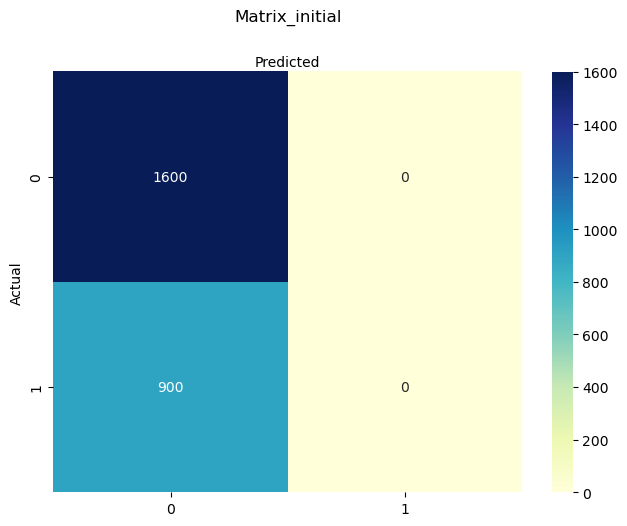

In [78]:
# Create the confusion matrix for the initial model
matrix_initial = metrics.confusion_matrix(y_test, y_pred_initial)
matrix_initial

# Create visual of the confusion matrix for the initial model
# Set up
class_names=[0,1]
figi, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create Heatmap
sns.heatmap(pd.DataFrame(matrix_initial), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matrix_initial', y=1.1)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show('Matrix_initial')

# Create Reduced Model:

Find which variables to keep in the reduced model through the RFE method:

In [79]:
reduced_vars = X_initial
X_reduced = [i for i in reduced_vars if i not in y]

modelr = LogisticRegression()
rfe = RFE(modelr, n_features_to_select=2, step=1)
rfe = rfe.fit(X_initial, y)
variables =[]
print("The variables selected for the reduced model are: ")
for i in range (X_initial.shape[1]):
    if rfe.support_[i] ==True:
        variables.append(X_initial.columns[i])
        print("Column: %d, Rank: %.2f, Variable: %s" %
             (i, rfe.ranking_[i], X_initial.columns[i]))

The variables selected for the reduced model are: 
Column: 4, Rank: 1.00, Variable: Initial_admin_Emergency
Column: 16, Rank: 1.00, Variable: Asthma_Yes


Create a reduced multilogistical regression model to predict if a patient can be expected to be readmitted within a month based on the variables chosen:

In [80]:
# Define the X and y variables
X_reduced = medical_df_prep[['Initial_admin_Emergency', 'Asthma_Yes']]
y = medical_df_prep['ReAdmis_Yes']

In [81]:
# Split X and y into training and testing sets (75% for training, 25% for testing)
X_reduced_train, X_reduced_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.25, random_state=9)

In [82]:
# Set up the reduced model
model_reduced = LogisticRegression(random_state=9)
# Fit the reduced model
model_reduced.fit(X_reduced_train, y_train)
# Run the fit model
y_pred_reduced = model_reduced.predict(X_reduced_test)

Review the results of the reduced model:

In [83]:
print("The classes for the result of the reduced model are: ", (model_reduced.classes_))
print("The intercept of the reduced model equation is: ", (model_reduced.intercept_))
print("The coefficients of the reduced model equation for each variable respecively is: ", (model_reduced.coef_))
model_reduced.predict_proba(X_reduced)
model_reduced.predict(X_reduced)
print("The reduced model accuracy score is: ", (model_reduced.score(X_reduced, y)))

The classes for the result of the reduced model are:  [0 1]
The intercept of the reduced model equation is:  [-0.53338398]
The coefficients of the reduced model equation for each variable respecively is:  [[ 0.04627267 -0.08869643]]
The reduced model accuracy score is:  0.6331


Review the confusion matrix for the results of the reduced model:

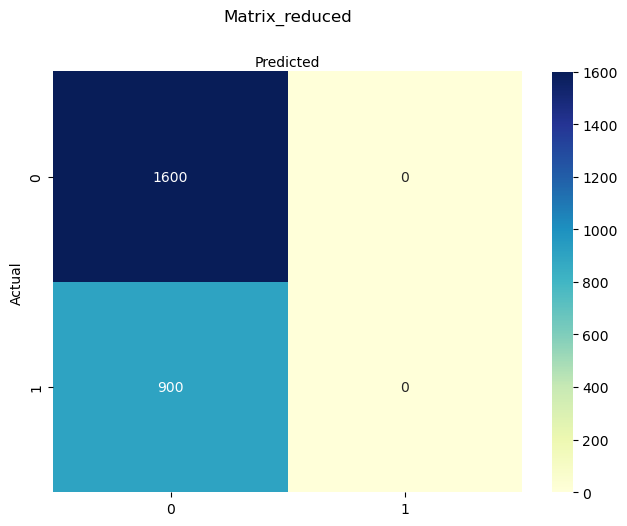

In [84]:
# Create the confusion matrix for the reduced model
matrix_reduced = metrics.confusion_matrix(y_test, y_pred_reduced)
matrix_reduced

# Create visual of the confusion matrix for the reduced model
# Set up
class_names=[0,1]
figi, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create Heatmap
sns.heatmap(pd.DataFrame(matrix_reduced), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matrix_reduced', y=1.1)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show('Matrix_reduced')

# Model Equation:

The equation for the reduced model is:

ln(p/(1-p)) = (-0.533) + (0.046)(Initial_admin_Emergency) + (-0.089)(Asthma_Yes)